In [1]:
import os
notebook_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
data_dir = os.path.join(root_dir, 'data')

import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import ipywidgets as widgets
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import brier_score_loss, make_scorer, log_loss, mean_squared_error
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.metrics import log_loss
from IPython.display import display, HTML
import pickle
from sklearn.model_selection import GroupKFold, RandomizedSearchCV, cross_val_predict
import scipy
from sklearn.preprocessing import OneHotEncoder

def uniform_distribution(lo, hi):
    return scipy.stats.uniform(lo, hi - lo)
def ProbaScoreProxy(y_true, y_probs, proxied_func, **kwargs):
    return proxied_func(y_true, y_probs, **kwargs)
from sklearn import calibration
from utils import get_model_outputs
import functools
import sys

pd.DataFrame.groupby.__setattr__("as_index",  False)

In [2]:
def normalize_df(df, anchor_df=None):
    for col in df.columns:
        data = df[col]
        if anchor_df is None:
            df[col] = (data - np.min(data)) / (np.max(data) - np.min(data))
        else:
            df[col] = (data - np.min(anchor_df[col])) / (np.max(anchor_df[col]) - np.min(anchor_df[col]))
    return df

def create_train_test_val_df(
    df,
    input_names,
    output_name,
    group_col="game_code",
    mask_test_season=2021,
    mask_val_season=2020,
):
    mask_train = ~(df.season.isin([mask_test_season, mask_val_season]))
    mask_test = (df.season == mask_test_season)
    mask_val = (df.season == mask_val_season)
    X_train = normalize_df(df.loc[mask_train, input_names])
    y_train = df.loc[mask_train, output_name]
    group_train = df.loc[mask_train, group_col]
    X_test = normalize_df(df.loc[mask_test, input_names], df.loc[mask_train, input_names])
    y_test = df.loc[mask_test, output_name]
    group_test = df.loc[mask_test, group_col]
    X_val = normalize_df(df.loc[mask_val, input_names], df.loc[mask_train, input_names])
    y_val = df.loc[mask_val, output_name]
    group_val = df.loc[mask_val, group_col]
    return X_train, y_train, group_train, X_test, y_test, group_test, X_val, y_val, group_val

In [3]:
event_df = pd.read_parquet(os.path.join(data_dir, "event_data.parquet"))
event_df = event_df.drop_duplicates(["nevent", "game_code"]).reset_index(drop=True)
odds_df = pd.read_parquet(os.path.join(data_dir, "odds_data.parquet"))
odds_df = odds_df.drop_duplicates("game_code")
event_ids = event_df[["event_id", "event_name"]].drop_duplicates().sort_values("event_id").reset_index(drop=True)
event_ids.to_csv(os.path.join(data_dir, "event_ids.csv"))


event_df["half"] = round((event_df["quarter"] + 0.01) / 2)
event_df["home_timeout"] = np.where(((event_df["event_id"]==57)&(event_df["home_team_has_ball"]==1))|((event_df["event_id"]==58)&(event_df["home_team_has_ball"]==0)), 1, 0)
event_df["away_timeout"] = np.where(((event_df["event_id"]==57)&(event_df["home_team_has_ball"]==0))|((event_df["event_id"]==58)&(event_df["home_team_has_ball"]==1)), 1, 0)
event_df["home_timeouts_remaining"] = np.clip(3 - event_df.groupby(["game_code", "half"])["home_timeout"].cumsum(), 0, 3)
event_df["away_timeouts_remaining"] = np.clip(3 - event_df.groupby(["game_code", "half"])["away_timeout"].cumsum(), 0, 3)
event_df["time_left_in_game"] = np.where(event_df["quarter"] <= 4, event_df["play_start_time"] + (4 - event_df["quarter"]) * 900, event_df["play_start_time"])
event_df["time_elapsed"] = 900 - event_df["play_start_time"] + (event_df["quarter"] - 1) * 900


event_df[["cur_spread", "cur_over_under"]] = event_df.merge(odds_df, how="left", on="game_code")[["cur_spread", "cur_over_under"]].fillna({"cur_spread": np.mean(odds_df["cur_spread"]), "cur_over_under": np.mean(odds_df["cur_over_under"])})
event_df["sequence"] = event_df["continuation"].groupby(event_df["continuation"].eq(0).cumsum()).cumsum()
event_df["play_start_id"] = event_df["nevent"] - event_df["sequence"]

turnover_ids = [9, 16]
# mask_turnover_on_downs = (event_df["down"]==4)&(event_df["field_goal_attempt"]==0)&(event_df["punt"]==0)&(event_df["yards_gained"]<event_df["ytg"])&(event_df["home_team_has_ball"]!=event_df.shift(-1)["home_team_has_ball"])
event_df["turnover"] = np.where(event_df["event_id"].isin(turnover_ids), 1, 0)
event_df["touchdown_scored"] = np.where(event_df["home_score_added"]+event_df["away_score_added"]>=6, 1, 0)
event_df["fieldgoal_made"] = np.where(event_df["home_score_added"]+event_df["away_score_added"]==3, 1, 0)

play_outcome_aggregate =event_df[["game_code", "play_start_id", "turnover", "touchdown_scored", "fieldgoal_made", "first_down"]].groupby(["game_code", "play_start_id"], as_index=False).sum()
# touchdown_key_df =event_df[["game_code", "play_start_id", "turnover"]].groupby(["game_code", "play_start_id"], as_index=False).sum()
event_df["touchdown_in_play"] = np.clip(event_df.merge(play_outcome_aggregate,on=["game_code", "play_start_id"], how="left")["touchdown_scored_y"], 0, 1)
event_df["turnover_in_play"] = np.clip(event_df.merge(play_outcome_aggregate,on=["game_code", "play_start_id"], how="left")["turnover_y"], 0, 1)
event_df["field_goal_in_play"] = np.clip(event_df.merge(play_outcome_aggregate,on=["game_code", "play_start_id"], how="left")["fieldgoal_made_y"], 0, 1)
event_df["first_down_in_play"] = np.clip(event_df.merge(play_outcome_aggregate,on=["game_code", "play_start_id"], how="left")["first_down_y"], 0, 1)


# drive_outcome_aggregate =event_df[["game_code", "off_team_id", "drive_id", "turnover", "touchdown_scored", "fieldgoal_made"]].groupby(["game_code", "off_team_id", "drive_id"], as_index=False).sum()
# event_df["touchdown_in_drive"] = np.clip(event_df.merge(drive_outcome_aggregate,on=["game_code", "drive_id", "off_team_id"], how="left")["touchdown_scored_y"], 0, 1)
# event_df["turnover_in_drive"] = np.clip(event_df.merge(drive_outcome_aggregate,on=["game_code", "drive_id", "off_team_id"], how="left")["turnover_y"], 0, 1)
# event_df["field_goal_in_drive"] = np.clip(event_df.merge(drive_outcome_aggregate,on=["game_code", "drive_id", "off_team_id"], how="left")["fieldgoal_made_y"], 0, 1)

event_df["play_outcome"] = np.where(
    (event_df["touchdown_in_play"]==1)&(event_df["turnover_in_play"]==1), "defensive_touchdown", 
    np.where((event_df["touchdown_in_play"]==1)&(event_df["turnover_in_play"]==0), "offensive_touchdown",
    np.where((event_df["field_goal_in_play"]==1), "field_goal_made",
    np.where((event_df["first_down_in_play"]==1), "first_down",
    np.where((event_df["touchdown_in_play"]==0)&(event_df["turnover_in_play"]==1), "turnover", "none"
)))))
drive_description_matrix = {
    7: "punt",
    9: "turnover",
    14: "turnover",
    17: "field_goal_made",
    18: "punt",
    20: "safety",
    35: "field_goal_missed",
    36: "field_goal_missed",
    37: "touch_down",
    38: "clock",
    39: "clock",
    40: "turnover_on_downs",
    42: "field_goal_made",
    51: "clock",
}
event_df["drive_outcome_desc_basic"] = event_df["drive_outcome_id"].map(drive_description_matrix)

# event_df["drive_outcome"] = np.where(
#     (event_df["touchdown_in_drive"]==1)&(event_df["turnover_in_drive"]==1), "defensive_touchdown", 
#     np.where((event_df["touchdown_in_drive"]==1)&(event_df["turnover_in_drive"]==0), "offensive_touchdown",
#     np.where((event_df["field_goal_in_drive"]==1), "field_goal_made",
#     np.where((event_df["touchdown_in_drive"]==0)&(event_df["turnover_in_drive"]==1), "turnover", "none"
# ))))
scrimmage_plays_we_want = [1, 2, 3, 4, 7, 9, 14, 17, 18, 35]

In [4]:
output_name = "play_outcome"

model_df = deepcopy(event_df)
model_df["time_left_in_half"] = event_df["time_left_in_game"] - ((2 - event_df["half"]) * 1800)
model_df["from_scrimmage"] = np.where(event_df["event_id"].isin([22, 52, 53, 55, 47, 54, 56]), 0, event_df["from_scrimmage"])
model_df["ytg"] = np.where(model_df["from_scrimmage"] == 0, -1, event_df["ytg"])
model_df["down"] = np.where(model_df["from_scrimmage"] == 0, 0, event_df["down"])
model_df["home_team_has_ball"] = np.where(event_df["event_id"].isin([5]), 1 - event_df["home_team_has_ball"], event_df["home_team_has_ball"])
model_df["yd_from_goal"] = np.where(model_df["from_scrimmage"] == 0, -1, event_df["yd_from_goal"])


input_names = [
    # 'time_left_in_game',
    'time_left_in_half',
    'half',
    'current_score_diff',
    'current_score_total',
    'cur_spread',
    'cur_over_under',
    'home_timeouts_remaining',
    'away_timeouts_remaining',
    # 'kick_off',
    'punt',
    # 'point_after_kick',
    # 'two_point_attempt',
    'field_goal_attempt',
    # 'from_scrimmage',
    'ytg',
    'yd_from_goal',
    'down',
    'home_team_has_ball',

]
mask_model = (
    (model_df.continuation==0)&
    (model_df.down!=0)&
    (model_df.play_counts==1)&
    (model_df.event_id.isin(scrimmage_plays_we_want))&
    (model_df[input_names+[output_name]].notna().all(axis=1))&
    (model_df["from_scrimmage"]==1)&
    (model_df["overtime"]==0)
)
X_train, y_train, group_train, X_test, y_test, group_test, X_val, y_val, group_val = create_train_test_val_df(model_df[mask_model], input_names, output_name)

# mlp_play_outcome = MLPClassifier(hidden_layer_sizes=[100], verbose=True, early_stopping=True, n_iter_no_change=5, random_state=1)
# mlp_play_outcome.fit(X_train, y_train)
# rf_play_outcome = RandomForestClassifier(n_estimators=200, max_depth=15, verbose=100, n_jobs=-1, random_state=1)
# rf_play_outcome.fit(X_train, y_train)
# pickle.dump(mlp_play_outcome, open(os.path.join(root_dir, 'models/mlp_play_outcome.p'), 'wb'))
# pickle.dump(rf_play_outcome, open(os.path.join(root_dir, 'models/rf_play_outcome.p'), 'wb'))



# logit_play_outcome_basic = LogisticRegression(solver='liblinear', random_state=0)
# logit_play_outcome_basic.fit(X_train, y_train)
# pickle.dump(logit_play_outcome_basic, open(os.path.join(root_dir, 'models/logit_play_outcome_basic.p'), 'wb'))


mlp_play_outcome = pickle.load(open(os.path.join(root_dir, "models/mlp_play_outcome.p"), 'rb'))
rf_play_outcome = pickle.load(open(os.path.join(root_dir, "models/rf_play_outcome.p"), 'rb'))
logit_play_outcome_basic = pickle.load(open(os.path.join(root_dir, "models/logit_play_outcome_basic.p"), 'rb'))
os.system('say "done"')


Iteration 1, loss = 0.70114336
Validation score: 0.730224


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 2, loss = 0.66614828
Validation score: 0.730739


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 3, loss = 0.66235366
Validation score: 0.731859


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 4, loss = 0.66034181
Validation score: 0.731791


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 5, loss = 0.65891457
Validation score: 0.731836


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 6, loss = 0.65795752
Validation score: 0.730538


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 7, loss = 0.65765964
Validation score: 0.731747


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 8, loss = 0.65678991
Validation score: 0.731635


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 9, loss = 0.65628045
Validation score: 0.732687


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 10, loss = 0.65583885
Validation score: 0.732821


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 11, loss = 0.65543774
Validation score: 0.732597


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 12, loss = 0.65507241
Validation score: 0.733135


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 13, loss = 0.65475281
Validation score: 0.732441


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 14, loss = 0.65458241
Validation score: 0.733448


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 15, loss = 0.65423871
Validation score: 0.731903


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 16, loss = 0.65399698
Validation score: 0.733045


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 17, loss = 0.65396958
Validation score: 0.731366


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 18, loss = 0.65365224
Validation score: 0.733045


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 19, loss = 0.65364869
Validation score: 0.732172


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 20, loss = 0.65336739
Validation score: 0.733135
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
building tree 1 of 200building tree 2 of 200
building tree 3 of 200building tree 4 of 200
building tree 5 of 200
building tree 6 of 200


building tree 7 of 200building tree 8 of 200

building tree 9 of 200[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s

building tree 10 of 200[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s

building tree 11 of 200[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.1s
building tree 12 of 200

[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
building tree 13 of 200[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.1s

building tree 14 of 200[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.1s

building tree 15 of 200[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.1s

building tree 16 of 200[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.3s

building tree 17 of 200[Parallel(n_jobs=-1)]: Do

0

In [7]:
def ProbaScoreProxy(y_true, y_probs, proxied_func, **kwargs):
    return proxied_func(y_true, y_probs, **kwargs)


log_loss_scorer = make_scorer(
    ProbaScoreProxy,
    greater_is_better=False,  # True
    needs_proba=True,
    proxied_func=log_loss,
)

In [10]:
y_train

2               none
3               none
4         first_down
5               none
6         first_down
             ...    
698479      turnover
698481          none
698483          none
698485          none
698487          none
Name: play_outcome, Length: 446629, dtype: object

In [18]:
cv=GroupKFold(n_splits=3)
rf_grid = {
    "n_estimators": np.linspace(start=50, stop=500, num=10, dtype=int),
    "max_features": ["auto", "sqrt"],
    "max_depth": np.linspace(5, 15, num=11, dtype=int),
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False],
}
rf_play_outcome_search_model = RandomForestClassifier(verbose=1, n_jobs=-1, random_state=1)
# search_rf_play_outcome = RandomizedSearchCV(rf_play_outcome_search_model, rf_grid, scoring=log_loss_scorer,cv=cv,random_state=42,n_iter=30,n_jobs=1,verbose=100)
# search_rf_play_outcome.fit(X_train,y_train,groups=group_train)
# pickle.dump(search_rf_play_outcome, open(os.path.join(root_dir, 'models/search_rf_play_outcome.p'), 'wb'))
search_rf_play_outcome = pickle.load(open(os.path.join(root_dir, "models/search_rf_play_outcome.p"), 'rb'))
os.system('say "done"')
search_rf_play_outcome

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3; 1/30] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=250


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   18.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.8s finished


[CV 1/3; 1/30] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=250;, score=-0.664 total time=  21.1s
[CV 2/3; 1/30] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=250


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   18.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.9s finished


[CV 2/3; 1/30] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=250;, score=-0.666 total time=  21.0s
[CV 3/3; 1/30] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=250


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   18.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.8s finished


[CV 3/3; 1/30] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=250;, score=-0.662 total time=  20.6s
[CV 1/3; 2/30] START bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   33.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    1.4s finished


[CV 1/3; 2/30] END bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=-0.660 total time=  36.4s
[CV 2/3; 2/30] START bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   33.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    1.5s finished


[CV 2/3; 2/30] END bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=-0.663 total time=  36.4s
[CV 3/3; 2/30] START bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   34.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    1.4s finished


[CV 3/3; 2/30] END bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=-0.658 total time=  37.0s
[CV 1/3; 3/30] START bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV 1/3; 3/30] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=-0.670 total time=   4.7s
[CV 2/3; 3/30] START bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV 2/3; 3/30] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=-0.673 total time=   4.7s
[CV 3/3; 3/30] START bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV 3/3; 3/30] END bootstrap=True, max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=-0.669 total time=   4.7s
[CV 1/3; 4/30] START bootstrap=True, max_depth=12, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=250


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   17.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.8s finished


[CV 1/3; 4/30] END bootstrap=True, max_depth=12, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=250;, score=-0.661 total time=  19.4s
[CV 2/3; 4/30] START bootstrap=True, max_depth=12, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=250


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   18.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.9s finished


[CV 2/3; 4/30] END bootstrap=True, max_depth=12, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=250;, score=-0.665 total time=  20.5s
[CV 3/3; 4/30] START bootstrap=True, max_depth=12, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=250


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   17.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.8s finished


[CV 3/3; 4/30] END bootstrap=True, max_depth=12, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=250;, score=-0.660 total time=  20.1s
[CV 1/3; 5/30] START bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV 1/3; 5/30] END bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=-0.664 total time=   5.2s
[CV 2/3; 5/30] START bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV 2/3; 5/30] END bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=-0.667 total time=   5.2s
[CV 3/3; 5/30] START bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV 3/3; 5/30] END bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=-0.662 total time=   5.2s
[CV 1/3; 6/30] START bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   19.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.9s finished


[CV 1/3; 6/30] END bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300;, score=-0.664 total time=  21.9s
[CV 2/3; 6/30] START bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   19.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.9s finished


[CV 2/3; 6/30] END bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300;, score=-0.667 total time=  22.2s
[CV 3/3; 6/30] START bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   19.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.9s finished


[CV 3/3; 6/30] END bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300;, score=-0.662 total time=  21.8s
[CV 1/3; 7/30] START bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=150


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   13.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.6s finished


[CV 1/3; 7/30] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=150;, score=-0.659 total time=  15.6s
[CV 2/3; 7/30] START bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=150


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   13.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.6s finished


[CV 2/3; 7/30] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=150;, score=-0.662 total time=  15.7s
[CV 3/3; 7/30] START bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=150


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   13.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.6s finished


[CV 3/3; 7/30] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=150;, score=-0.657 total time=  15.6s
[CV 1/3; 8/30] START bootstrap=False, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=150


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   11.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.5s finished


[CV 1/3; 8/30] END bootstrap=False, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=150;, score=-0.664 total time=  13.3s
[CV 2/3; 8/30] START bootstrap=False, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=150


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   11.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.5s finished


[CV 2/3; 8/30] END bootstrap=False, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=150;, score=-0.667 total time=  13.1s
[CV 3/3; 8/30] START bootstrap=False, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=150


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   12.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.7s finished


[CV 3/3; 8/30] END bootstrap=False, max_depth=11, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=150;, score=-0.662 total time=  15.3s
[CV 1/3; 9/30] START bootstrap=True, max_depth=14, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=450


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   40.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done 450 out of 450 | elapsed:    1.8s finished


[CV 1/3; 9/30] END bootstrap=True, max_depth=14, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=450;, score=-0.659 total time=  44.3s
[CV 2/3; 9/30] START bootstrap=True, max_depth=14, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=450


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   40.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done 450 out of 450 | elapsed:    1.8s finished


[CV 2/3; 9/30] END bootstrap=True, max_depth=14, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=450;, score=-0.662 total time=  43.7s
[CV 3/3; 9/30] START bootstrap=True, max_depth=14, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=450


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   44.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 450 out of 450 | elapsed:    2.0s finished


[CV 3/3; 9/30] END bootstrap=True, max_depth=14, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=450;, score=-0.657 total time=  48.6s
[CV 1/3; 10/30] START bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   30.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.8s finished


[CV 1/3; 10/30] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=-0.690 total time=  33.7s
[CV 2/3; 10/30] START bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   27.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.4s finished


[CV 2/3; 10/30] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=-0.692 total time=  30.9s
[CV 3/3; 10/30] START bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   33.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.9s finished


[CV 3/3; 10/30] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=-0.686 total time=  36.8s
[CV 1/3; 11/30] START bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=350


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:   31.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 350 out of 350 | elapsed:    1.5s finished


[CV 1/3; 11/30] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=350;, score=-0.681 total time=  35.0s
[CV 2/3; 11/30] START bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=350


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:   21.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 350 out of 350 | elapsed:    1.1s finished


[CV 2/3; 11/30] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=350;, score=-0.684 total time=  24.2s
[CV 3/3; 11/30] START bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=350


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:   25.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 350 out of 350 | elapsed:    1.3s finished


[CV 3/3; 11/30] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=350;, score=-0.678 total time=  29.6s
[CV 1/3; 12/30] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=450


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   33.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 450 out of 450 | elapsed:    1.6s finished


[CV 1/3; 12/30] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=450;, score=-0.664 total time=  36.8s
[CV 2/3; 12/30] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=450


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   30.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 450 out of 450 | elapsed:    1.6s finished


[CV 2/3; 12/30] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=450;, score=-0.667 total time=  33.4s
[CV 3/3; 12/30] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=450


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   30.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 450 out of 450 | elapsed:    1.4s finished


[CV 3/3; 12/30] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=450;, score=-0.662 total time=  33.4s
[CV 1/3; 13/30] START bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV 1/3; 13/30] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=-0.689 total time=   4.5s
[CV 2/3; 13/30] START bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV 2/3; 13/30] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=-0.693 total time=   4.4s
[CV 3/3; 13/30] START bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV 3/3; 13/30] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=-0.688 total time=   4.2s
[CV 1/3; 14/30] START bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   12.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.6s finished


[CV 1/3; 14/30] END bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150;, score=-0.660 total time=  14.6s
[CV 2/3; 14/30] START bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   11.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.6s finished


[CV 2/3; 14/30] END bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150;, score=-0.664 total time=  13.9s
[CV 3/3; 14/30] START bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   11.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.8s finished


[CV 3/3; 14/30] END bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150;, score=-0.659 total time=  14.4s
[CV 1/3; 15/30] START bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   13.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.9s finished


[CV 1/3; 15/30] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300;, score=-0.699 total time=  16.1s
[CV 2/3; 15/30] START bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   21.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    1.4s finished


[CV 2/3; 15/30] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300;, score=-0.702 total time=  26.6s
[CV 3/3; 15/30] START bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   21.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    1.2s finished


[CV 3/3; 15/30] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300;, score=-0.696 total time=  25.4s
[CV 1/3; 16/30] START bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=250


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   26.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    1.5s finished


[CV 1/3; 16/30] END bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=250;, score=-0.660 total time=  29.6s
[CV 2/3; 16/30] START bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=250


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   30.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    1.1s finished


[CV 2/3; 16/30] END bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=250;, score=-0.663 total time=  33.8s
[CV 3/3; 16/30] START bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=250


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   24.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.9s finished


[CV 3/3; 16/30] END bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=250;, score=-0.658 total time=  26.9s
[CV 1/3; 17/30] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


[CV 1/3; 17/30] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=-0.664 total time=  10.0s
[CV 2/3; 17/30] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished


[CV 2/3; 17/30] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=-0.666 total time=  10.3s
[CV 3/3; 17/30] START bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


[CV 3/3; 17/30] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=-0.663 total time=  10.6s
[CV 1/3; 18/30] START bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   40.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.6s finished


[CV 1/3; 18/30] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=-0.667 total time=  44.5s
[CV 2/3; 18/30] START bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   43.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.7s finished


[CV 2/3; 18/30] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=-0.670 total time=  46.7s
[CV 3/3; 18/30] START bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   44.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.6s finished


[CV 3/3; 18/30] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=-0.664 total time=  47.4s
[CV 1/3; 19/30] START bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   35.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    1.4s finished


[CV 1/3; 19/30] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300;, score=-0.659 total time=  38.1s
[CV 2/3; 19/30] START bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   38.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    2.1s finished


[CV 2/3; 19/30] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300;, score=-0.662 total time=  42.3s
[CV 3/3; 19/30] START bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   35.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    1.5s finished


[CV 3/3; 19/30] END bootstrap=False, max_depth=14, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300;, score=-0.657 total time=  38.7s
[CV 1/3; 20/30] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV 1/3; 20/30] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=-0.699 total time=   4.3s
[CV 2/3; 20/30] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV 2/3; 20/30] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=-0.702 total time=   4.0s
[CV 3/3; 20/30] START bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.3s finished


[CV 3/3; 20/30] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=-0.699 total time=   4.5s
[CV 1/3; 21/30] START bootstrap=True, max_depth=14, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   29.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    1.4s finished


[CV 1/3; 21/30] END bootstrap=True, max_depth=14, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300;, score=-0.659 total time=  32.3s
[CV 2/3; 21/30] START bootstrap=True, max_depth=14, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   26.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    1.3s finished


[CV 2/3; 21/30] END bootstrap=True, max_depth=14, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300;, score=-0.662 total time=  29.6s
[CV 3/3; 21/30] START bootstrap=True, max_depth=14, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   24.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    1.1s finished


[CV 3/3; 21/30] END bootstrap=True, max_depth=14, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300;, score=-0.657 total time=  26.7s
[CV 1/3; 22/30] START bootstrap=False, max_depth=12, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV 1/3; 22/30] END bootstrap=False, max_depth=12, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=-0.662 total time=   6.0s
[CV 2/3; 22/30] START bootstrap=False, max_depth=12, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV 2/3; 22/30] END bootstrap=False, max_depth=12, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=-0.664 total time=   5.8s
[CV 3/3; 22/30] START bootstrap=False, max_depth=12, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV 3/3; 22/30] END bootstrap=False, max_depth=12, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=-0.661 total time=   5.7s
[CV 1/3; 23/30] START bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   31.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.3s finished


[CV 1/3; 23/30] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500;, score=-0.670 total time=  34.6s
[CV 2/3; 23/30] START bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   28.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.5s finished


[CV 2/3; 23/30] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500;, score=-0.673 total time=  32.0s
[CV 3/3; 23/30] START bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   29.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.6s finished


[CV 3/3; 23/30] END bootstrap=True, max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500;, score=-0.668 total time=  32.8s
[CV 1/3; 24/30] START bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


[CV 1/3; 24/30] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=-0.681 total time=   8.0s
[CV 2/3; 24/30] START bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


[CV 2/3; 24/30] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=-0.683 total time=   8.1s
[CV 3/3; 24/30] START bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


[CV 3/3; 24/30] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=-0.677 total time=   8.0s
[CV 1/3; 25/30] START bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   25.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    1.2s finished


[CV 1/3; 25/30] END bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300;, score=-0.661 total time=  28.1s
[CV 2/3; 25/30] START bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   29.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    1.5s finished


[CV 2/3; 25/30] END bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300;, score=-0.663 total time=  32.6s
[CV 3/3; 25/30] START bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   23.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    1.1s finished


[CV 3/3; 25/30] END bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300;, score=-0.658 total time=  26.3s
[CV 1/3; 26/30] START bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   25.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    1.1s finished


[CV 1/3; 26/30] END bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300;, score=-0.660 total time=  28.2s
[CV 2/3; 26/30] START bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   26.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    1.1s finished


[CV 2/3; 26/30] END bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300;, score=-0.663 total time=  28.7s
[CV 3/3; 26/30] START bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   25.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    1.1s finished


[CV 3/3; 26/30] END bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300;, score=-0.658 total time=  28.6s
[CV 1/3; 27/30] START bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.6s finished


[CV 1/3; 27/30] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=-0.670 total time=  14.6s
[CV 2/3; 27/30] START bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.6s finished


[CV 2/3; 27/30] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=-0.673 total time=  15.0s
[CV 3/3; 27/30] START bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.6s finished


[CV 3/3; 27/30] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=-0.669 total time=  14.8s
[CV 1/3; 28/30] START bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   10.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.6s finished


[CV 1/3; 28/30] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-0.681 total time=  12.6s
[CV 2/3; 28/30] START bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   10.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.6s finished


[CV 2/3; 28/30] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-0.684 total time=  12.4s
[CV 3/3; 28/30] START bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    9.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.6s finished


[CV 3/3; 28/30] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-0.679 total time=  12.0s
[CV 1/3; 29/30] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   20.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.9s finished


[CV 1/3; 29/30] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300;, score=-0.664 total time=  22.6s
[CV 2/3; 29/30] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   19.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.9s finished


[CV 2/3; 29/30] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300;, score=-0.667 total time=  22.4s
[CV 3/3; 29/30] START bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   20.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    1.0s finished


[CV 3/3; 29/30] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300;, score=-0.662 total time=  23.6s
[CV 1/3; 30/30] START bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   22.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    1.9s finished


[CV 1/3; 30/30] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300;, score=-0.667 total time=  26.7s
[CV 2/3; 30/30] START bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   20.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    1.0s finished


[CV 2/3; 30/30] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300;, score=-0.670 total time=  23.4s
[CV 3/3; 30/30] START bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   20.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    1.4s finished


[CV 3/3; 30/30] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300;, score=-0.665 total time=  24.4s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   54.4s finished


RandomizedSearchCV(cv=GroupKFold(n_splits=3),
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=1,
                                                    verbose=1),
                   n_iter=30, n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500])},
                   random_state=42,
                   scoring=make_scorer(ProbaScoreProxy, greater_is_better=False, needs_proba=True, proxied_func=<function log_loss at 0x7fdd6f0a0790>),
                   verbose=100)

In [ ]:
import catboost as cb
curr_val_pool_score_change =cb.Pool(
        data=X_val,
        label=y_val,
        feature_names=input_names,
)

CLASSIFIER_PARAMS = {
    # "n_estimators": 10,
    "num_trees": 1000,
    "auto_class_weights": "Balanced",

    # "loss_function": JITRmseObjective(),
    # "eval_metric": JITRmseMetric(),
    **COMPUTE_PARAMS,
}
HPO_PARAMS = {"n_jobs": 1}

cv=GroupKFold(n_splits=3)
cb_play_outcome_search_model = cb.CatBoostClassifier()


In [53]:
logit_play_outcome_basic

,time_left_in_half,time_left_in_half_sq,half,current_score_diff,current_score_total,cur_spread,cur_over_under,home_timeouts_remaining,away_timeouts_remaining,punt,...,down_yd_from_goal_3,down_yd_from_goal_4,down_ytg_1_sq,down_ytg_2_sq,down_ytg_3_sq,down_ytg_4_sq,down_yd_from_goal_1_sq,down_yd_from_goal_2_sq,down_yd_from_goal_3_sq,down_yd_from_goal_4_sq
2,0.997222,0.994452,0.0,0.453704,0.000000,0.500000,0.630252,1.000000,1.000000,0.0,...,0.000000,0.000000,0.0625,0.000000,0.0000,0.000000,0.719927,0.000000,0.000000,0.000000
3,0.977778,0.956049,0.0,0.453704,0.000000,0.500000,0.630252,1.000000,1.000000,0.0,...,0.000000,0.000000,0.0000,0.025310,0.0000,0.000000,0.000000,0.669421,0.000000,0.000000
4,0.974444,0.949542,0.0,0.453704,0.000000,0.500000,0.630252,1.000000,1.000000,0.0,...,0.818182,0.000000,0.0000,0.000000,0.0196,0.000000,0.000000,0.000000,0.669421,0.000000
5,0.957222,0.916274,0.0,0.453704,0.000000,0.500000,0.630252,1.000000,1.000000,0.0,...,0.000000,0.000000,0.0625,0.000000,0.0000,0.000000,0.543720,0.000000,0.000000,0.000000
6,0.931111,0.866968,0.0,0.453704,0.000000,0.500000,0.630252,1.000000,1.000000,0.0,...,0.000000,0.000000,0.0000,0.025310,0.0000,0.000000,0.000000,0.499949,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698479,0.037778,0.001427,1.0,0.555556,0.485714,0.566667,0.823529,1.000000,0.666667,0.0,...,0.000000,0.000000,0.0000,0.051653,0.0000,0.000000,0.000000,0.573921,0.000000,0.000000
698481,0.031667,0.001003,1.0,0.555556,0.485714,0.566667,0.823529,1.000000,0.666667,0.0,...,0.000000,0.000000,0.0625,0.000000,0.0000,0.000000,0.355168,0.000000,0.000000,0.000000
698483,0.029444,0.000867,1.0,0.555556,0.485714,0.566667,0.823529,1.000000,0.333333,0.0,...,0.000000,0.000000,0.0000,0.116219,0.0000,0.000000,0.000000,0.417917,0.000000,0.000000
698485,0.028333,0.000803,1.0,0.555556,0.485714,0.566667,0.823529,1.000000,0.000000,0.0,...,0.676768,0.000000,0.0000,0.000000,0.1296,0.000000,0.000000,0.000000,0.458014,0.000000


RandomizedSearchCV(cv=GroupKFold(n_splits=3),
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=1,
                                                    verbose=1),
                   n_iter=30, n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500])},
                   random_state=42,
                   scoring=make_scorer(ProbaScoreProxy, greater_is_better=False, needs_proba=True, proxied_func=<function log_loss at 0x7fdd6f0a0790>),
                   verbose=100)

In [26]:
search_rf_play_outcome.best_score_

-0.6592814212251309

In [30]:



output_name = "drive_outcome_desc_basic"
mask_model = (
    (model_df.continuation==0)&
    (model_df.down!=0)&
    (model_df.play_counts==1)&
    (model_df.event_id.isin(scrimmage_plays_we_want))&
    (model_df[input_names+[output_name]].notna().all(axis=1))&
    (model_df["from_scrimmage"]==1)&
    (model_df["overtime"]==0)
)
X_train, y_train, group_train, X_test, y_test, group_test, X_val, y_val, group_val = create_train_test_val_df(model_df[mask_model], input_names, output_name)
# pd.concat([X_train, model_df[model_df["season"]<=2019][["event_name"]], y_train], axis=1)

# mlp_drive_outcome = MLPClassifier(hidden_layer_sizes=[100], verbose=True, early_stopping=True, n_iter_no_change=5, random_state=1)
# mlp_drive_outcome.fit(X_train, y_train)
# rf_drive_outcome = RandomForestClassifier(n_estimators=200, max_depth=15, verbose=100, n_jobs=-1, random_state=1)
# rf_drive_outcome.fit(X_train, y_train)
# pickle.dump(mlp_drive_outcome, open(os.path.join(root_dir, 'models/mlp_drive_outcome.p'), 'wb'))
# pickle.dump(rf_drive_outcome, open(os.path.join(root_dir, 'models/rf_drive_outcome.p'), 'wb'))
# logit_drive_outcome_basic = LogisticRegression(solver='liblinear', random_state=0)
# logit_drive_outcome_basic.fit(X_train, y_train)
# pickle.dump(logit_drive_outcome_basic, open(os.path.join(root_dir, 'models/logit_drive_outcome_basic.p'), 'wb'))

os.system('say "done"')

mlp_drive_outcome = pickle.load(open(os.path.join(root_dir, "models/mlp_drive_outcome.p"), 'rb'))
rf_drive_outcome = pickle.load(open(os.path.join(root_dir, "models/rf_drive_outcome.p"), 'rb'))
logit_drive_outcome_basic = pickle.load(open(os.path.join(root_dir, "models/logit_drive_outcome_basic.p"), 'rb'))

In [31]:
output_name = "play_outcome"

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(model_df[["down"]])
down_one_hot_cols = ["down_" + str(x) for x in enc.categories_[0]]
model_df[down_one_hot_cols] = pd.DataFrame(enc.transform(model_df[["down"]]).toarray(), columns=enc.categories_)

def square_value(df, cols):
    for col in cols:
        df[col + "_sq"] = df[col] ** 2
    return df

down_ytg_one_hot_cols = ["down_ytg_" + str(x) for x in enc.categories_[0]]
model_df[down_ytg_one_hot_cols] = model_df[down_one_hot_cols].T.mul(model_df["ytg"]).T

down_yd_from_goal_cols = ["down_yd_from_goal_" + str(x) for x in enc.categories_[0]]
model_df[down_yd_from_goal_cols] = model_df[down_one_hot_cols].T.mul(model_df["yd_from_goal"]).T
model_df = model_df.pipe(square_value, ["time_left_in_half"] + down_ytg_one_hot_cols + down_yd_from_goal_cols)
down_ytg_sq_one_hot_cols = ["down_ytg_" + str(x) + "_sq" for x in enc.categories_[0]]
down_yd_from_goal_sq_cols = ["down_yd_from_goal_" + str(x) + "_sq" for x in enc.categories_[0]]

input_names_advanced = [
    # 'time_left_in_game',
    'time_left_in_half',
    'time_left_in_half_sq',
    'half',
    'current_score_diff',
    'current_score_total',
    'cur_spread',
    'cur_over_under',
    'home_timeouts_remaining',
    'away_timeouts_remaining',
    # 'kick_off',
    'punt',
    # 'point_after_kick',
    # 'two_point_attempt',
    'field_goal_attempt',
    # 'from_scrimmage',
    # 'ytg',
    # 'yd_from_goal',
    # 'down',
    'home_team_has_ball',
] + down_one_hot_cols[2:] + down_ytg_one_hot_cols[1:] + down_yd_from_goal_cols[1:] + down_ytg_sq_one_hot_cols[1:] + down_yd_from_goal_sq_cols[1:]

mask_model = (
    (model_df.continuation==0)&
    (model_df.down!=0)&
    (model_df.play_counts==1)&
    (model_df.event_id.isin(scrimmage_plays_we_want))&
    (model_df[input_names_advanced+[output_name]].notna().all(axis=1))&
    (model_df["from_scrimmage"]==1)&
    (model_df["overtime"]==0)
)
X_train, y_train, group_train, X_test, y_test, group_test, X_val, y_val, group_val = create_train_test_val_df(model_df[mask_model], input_names_advanced, output_name)

# logit_play_outcome_advanced = LogisticRegression(solver='liblinear', random_state=0)
# logit_play_outcome_advanced.fit(X_train, y_train)
# pickle.dump(logit_play_outcome_advanced, open(os.path.join(root_dir, 'models/logit_play_outcome_advanced.p'), 'wb'))

logit_play_outcome_advanced = pickle.load(open(os.path.join(root_dir, "models/logit_play_outcome_advanced.p"), 'rb'))

# import statsmodels.api as sm
# logit_play_outcome_advanced = sm.MNLogit(pd.get_dummies(y_train)[:5000], sm.add_constant(X_train[:5000])).fit()
# X = sm.add_constant(X_train, prepend=False)
# logit_play_outcome_advanced = {}
# for col in pd.get_dummies(y_train).columns:
#     y = pd.get_dummies(y_train)[col]
#     logit_play_outcome_advanced[col] = sm.Logit(y, X)
#     logit_play_outcome_advanced[col+"_fit"] = logit_play_outcome_advanced[col].fit()
#     # logit_play_outcome_advanced[col] = sm.Logit(y[:50000], X[:50000]).fit()
#     print(logit_play_outcome_advanced[col+"_fit"].summary())
# logit_play_outcome_advanced = sm.MNLogit(y_train, X).fit(method='bfgs')
# logit_play_outcome_advanced = sm.MNLogit(y_train[:50000], X[:50000]).fit()


LogisticRegression(random_state=0, solver='liblinear')

In [7]:
# import statsmodels.api as sm
# X = sm.add_constant(X_train, prepend=False)
# logit_play_outcome_advanced_dict = {}
# for col in pd.get_dummies(y_train).columns:
#     y = pd.get_dummies(y_train)[col]
#     logit_play_outcome_advanced_dict[col] = sm.Logit(y, X)
#     logit_play_outcome_advanced_dict[col+"_fit"] = logit_play_outcome_advanced_dict[col].fit()
#     # logit_play_outcome_advanced[col] = sm.Logit(y[:50000], X[:50000]).fit()
#     print(logit_play_outcome_advanced_dict[col+"_fit"].summary())
# # logit_play_outcome_advanced_dict = sm.MNLogit(y_train, X).fit(method='bfgs')
# # logit_play_outcome_advanced_dict = sm.MNLogit(y_train[:50000], X[:50000]).fit()


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 35


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                            Logit Regression Results                           
Dep. Variable:     defensive_touchdown   No. Observations:               446629
Model:                           Logit   Df Residuals:                   446597
Method:                            MLE   Df Model:                           31
Date:                 Thu, 14 Apr 2022   Pseudo R-squ.:                     inf
Time:                         11:48:09   Log-Likelihood:                   -inf
converged:                       False   LL-Null:                        0.0000
Covariance Type:             nonrobust   LLR p-value:                     1.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
time_left_in_half          -0.4341      0.474     -0.916      0.360      -1.363       0.495
time_left_in_half_sq        0.1382      0.442      0.313      0.754      -0.728     

/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 35


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                           Logit Regression Results                           
Dep. Variable:        field_goal_made   No. Observations:               446629
Model:                          Logit   Df Residuals:                   446597
Method:                           MLE   Df Model:                           31
Date:                Thu, 14 Apr 2022   Pseudo R-squ.:                     inf
Time:                        11:48:15   Log-Likelihood:                   -inf
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
time_left_in_half          -0.0880      0.436     -0.202      0.840      -0.942       0.766
time_left_in_half_sq       -0.0180      0.440     -0.041      0.967      -0.879       0.843


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 12


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                           Logit Regression Results                           
Dep. Variable:             first_down   No. Observations:               446629
Model:                          Logit   Df Residuals:                   446597
Method:                           MLE   Df Model:                           31
Date:                Thu, 14 Apr 2022   Pseudo R-squ.:                     inf
Time:                        11:48:18   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
time_left_in_half           0.0572      0.056      1.014      0.311      -0.053       0.168
time_left_in_half_sq       -0.1681      0.052     -3.257      0.001      -0.269      -0.067


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 8


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                           Logit Regression Results                           
Dep. Variable:                   none   No. Observations:               446629
Model:                          Logit   Df Residuals:                   446597
Method:                           MLE   Df Model:                           31
Date:                Thu, 14 Apr 2022   Pseudo R-squ.:                     inf
Time:                        11:48:21   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
time_left_in_half          -0.0349      0.051     -0.677      0.498      -0.136       0.066
time_left_in_half_sq        0.1129      0.047      2.378      0.017       0.020       0.206


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 11


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                            Logit Regression Results                           
Dep. Variable:     offensive_touchdown   No. Observations:               446629
Model:                           Logit   Df Residuals:                   446597
Method:                            MLE   Df Model:                           31
Date:                 Thu, 14 Apr 2022   Pseudo R-squ.:                     inf
Time:                         11:48:24   Log-Likelihood:                   -inf
converged:                        True   LL-Null:                        0.0000
Covariance Type:             nonrobust   LLR p-value:                     1.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
time_left_in_half           0.3925      0.139      2.831      0.005       0.121       0.664
time_left_in_half_sq       -0.2803      0.136     -2.063      0.039      -0.547     

/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 35


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                           Logit Regression Results                           
Dep. Variable:               turnover   No. Observations:               446629
Model:                          Logit   Df Residuals:                   446597
Method:                           MLE   Df Model:                           31
Date:                Thu, 14 Apr 2022   Pseudo R-squ.:                     inf
Time:                        11:48:29   Log-Likelihood:                   -inf
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
time_left_in_half          -0.7241      0.160     -4.531      0.000      -1.037      -0.411
time_left_in_half_sq        0.5519      0.150      3.687      0.000       0.259       0.845


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


In [32]:
output_name = "drive_outcome_desc_basic"
mask_model = (
    (model_df.continuation==0)&
    (model_df.down!=0)&
    (model_df.play_counts==1)&
    (model_df.event_id.isin(scrimmage_plays_we_want))&
    (model_df[input_names_advanced+[output_name]].notna().all(axis=1))&
    (model_df["from_scrimmage"]==1)&
    (model_df["overtime"]==0)
)

X_train, y_train, group_train, X_test, y_test, group_test, X_val, y_val, group_val = create_train_test_val_df(model_df[mask_model], input_names_advanced, output_name)

# logit_drive_outcome_advanced = LogisticRegression(solver='liblinear', random_state=0)
# logit_drive_outcome_advanced.fit(X_train, y_train)
# pickle.dump(logit_drive_outcome_advanced, open(os.path.join(root_dir, 'models/logit_drive_outcome_advanced.p'), 'wb'))


logit_drive_outcome_advanced = pickle.load(open(os.path.join(root_dir, "models/logit_drive_outcome_advanced.p"), 'rb'))


LogisticRegression(random_state=0, solver='liblinear')

In [54]:
# import statsmodels.api as sm
# X = sm.add_constant(X_train, prepend=False)
# logit_drive_outcome_advanced_dict = {}
# for col in pd.get_dummies(y_train).columns:
#     y = pd.get_dummies(y_train)[col]
#     logit_drive_outcome_advanced_dict[col] = sm.Logit(y, X)
#     logit_drive_outcome_advanced_dict[col+"_fit"] = logit_drive_outcome_advanced_dict[col].fit()
#     print(logit_drive_outcome_advanced_dict[col+"_fit"].summary())



/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 35


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                           Logit Regression Results                           
Dep. Variable:                  clock   No. Observations:               446615
Model:                          Logit   Df Residuals:                   446583
Method:                           MLE   Df Model:                           31
Date:                Thu, 14 Apr 2022   Pseudo R-squ.:                     inf
Time:                        12:47:15   Log-Likelihood:                   -inf
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
time_left_in_half         -36.2086      0.398    -90.944      0.000     -36.989     -35.428
time_left_in_half_sq       27.8958      0.583     47.868      0.000      26.754      29.038


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 14


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                           Logit Regression Results                           
Dep. Variable:        field_goal_made   No. Observations:               446615
Model:                          Logit   Df Residuals:                   446583
Method:                           MLE   Df Model:                           31
Date:                Thu, 14 Apr 2022   Pseudo R-squ.:                     inf
Time:                        12:47:18   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
time_left_in_half           0.3484      0.060      5.832      0.000       0.231       0.465
time_left_in_half_sq       -0.2966      0.056     -5.340      0.000      -0.405      -0.188


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 35


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                           Logit Regression Results                           
Dep. Variable:      field_goal_missed   No. Observations:               446615
Model:                          Logit   Df Residuals:                   446583
Method:                           MLE   Df Model:                           31
Date:                Thu, 14 Apr 2022   Pseudo R-squ.:                     inf
Time:                        12:47:23   Log-Likelihood:                   -inf
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
time_left_in_half          -1.0900      0.120     -9.077      0.000      -1.325      -0.855
time_left_in_half_sq        0.9572      0.113      8.464      0.000       0.736       1.179


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 22


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                           Logit Regression Results                           
Dep. Variable:                   punt   No. Observations:               446615
Model:                          Logit   Df Residuals:                   446583
Method:                           MLE   Df Model:                           31
Date:                Thu, 14 Apr 2022   Pseudo R-squ.:                     inf
Time:                        12:47:28   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
time_left_in_half           3.0336      0.059     51.622      0.000       2.918       3.149
time_left_in_half_sq       -2.4798      0.052    -47.297      0.000      -2.583      -2.377


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 35


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                           Logit Regression Results                           
Dep. Variable:                 safety   No. Observations:               446615
Model:                          Logit   Df Residuals:                   446583
Method:                           MLE   Df Model:                           31
Date:                Thu, 14 Apr 2022   Pseudo R-squ.:                     inf
Time:                        12:47:34   Log-Likelihood:                   -inf
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
time_left_in_half           0.1237      0.722      0.171      0.864      -1.291       1.539
time_left_in_half_sq        0.1973      0.673      0.293      0.769      -1.122       1.517


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 14


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                           Logit Regression Results                           
Dep. Variable:             touch_down   No. Observations:               446615
Model:                          Logit   Df Residuals:                   446583
Method:                           MLE   Df Model:                           31
Date:                Thu, 14 Apr 2022   Pseudo R-squ.:                     inf
Time:                        12:47:37   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
time_left_in_half           1.4867      0.056     26.536      0.000       1.377       1.596
time_left_in_half_sq       -1.2176      0.052    -23.616      0.000      -1.319      -1.117


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 35


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                           Logit Regression Results                           
Dep. Variable:               turnover   No. Observations:               446615
Model:                          Logit   Df Residuals:                   446583
Method:                           MLE   Df Model:                           31
Date:                Thu, 14 Apr 2022   Pseudo R-squ.:                     inf
Time:                        12:47:44   Log-Likelihood:                   -inf
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
time_left_in_half          -0.5468      0.076     -7.205      0.000      -0.696      -0.398
time_left_in_half_sq        0.3162      0.070      4.533      0.000       0.179       0.453


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: inf
         Iterations: 35


LinAlgError: Singular matrix

In [34]:
model_df["yd_from_goal_bin"] = round((model_df["yd_from_goal"]+2.5)/ 5) * 5
model_df[mask_model&(model_df.field_goal_attempt==1)].groupby(["yd_from_goal_bin"], as_index=False).mean()[["yd_from_goal_bin", "yd_from_goal", "fieldgoal_made"]]


,yd_from_goal_bin,yd_from_goal,fieldgoal_made
0,5.0,2.770718,0.987109
1,10.0,7.534747,0.972473
2,15.0,12.493976,0.942930
3,20.0,17.551617,0.885080
4,25.0,22.500000,0.840554
5,30.0,27.550889,0.752932
6,35.0,32.410328,0.678995
7,40.0,36.437500,0.606360
8,45.0,42.257143,0.400000
9,50.0,46.406250,0.187500


In [38]:
for play_outcome in model_df[mask_model]["play_outcome"].drop_duplicates().sort_values():
    model_df[play_outcome + "_naive"] = pd.DataFrame(model_df[mask_model]["play_outcome"].value_counts())[pd.DataFrame(model_df[mask_model]["play_outcome"].value_counts()).index==play_outcome].values[0][0]/model_df[mask_model]["play_outcome"].count()
for drive_outcome in model_df[mask_model]["drive_outcome_desc_basic"].drop_duplicates().sort_values():
    model_df[drive_outcome + "_naive"] = pd.DataFrame(model_df[mask_model]["drive_outcome_desc_basic"].value_counts())[pd.DataFrame(model_df[mask_model]["drive_outcome_desc_basic"].value_counts()).index==drive_outcome].values[0][0]/model_df[mask_model]["drive_outcome_desc_basic"].count()


rf_play_class_names = ["rf_play_" + x for x in rf_play_outcome.classes_]
search_rf_play_class_names = ["search_rf_play_" + x for x in search_rf_play_outcome.classes_]
mlp_play_class_names = ["mlp_play_" + x for x in mlp_play_outcome.classes_]
rf_drive_class_names = ["rf_drive_" + x for x in rf_drive_outcome.classes_]
mlp_drive_class_names = ["mlp_drive_" + x for x in mlp_drive_outcome.classes_]
logit_play_basic_class_names = ["logit_basic_play_" + x for x in logit_play_outcome_basic.classes_]
logit_drive_basic_class_names = ["logit_basic_drive_" + x for x in logit_drive_outcome_basic.classes_]
logit_play_advanced_class_names = ["logit_advanced_play_" + x for x in logit_play_outcome_advanced.classes_]
logit_drive_advanced_class_names = ["logit_advanced_drive_" + x for x in logit_drive_outcome_advanced.classes_]
naive_play_class_names = [x + "_naive" for x in model_df[mask_model]["play_outcome"].drop_duplicates().sort_values()]
naive_drive_class_names = [x + "_naive" for x in model_df[mask_model]["drive_outcome_desc_basic"].drop_duplicates().sort_values()]
predict_df = normalize_df(model_df[mask_model][input_names], model_df[mask_model&(model_df.season<2020)])
predict_advanced_df = normalize_df(model_df[mask_model][input_names_advanced], model_df[mask_model&(model_df.season<2020)])
rf_play_outcome.verbose=0
rf_drive_outcome.verbose=0
search_rf_play_outcome.verbose=0
x_view = pd.concat([
    deepcopy(model_df[mask_model].reset_index()), 
    pd.DataFrame(logit_play_outcome_basic.predict_proba(predict_df), columns=logit_play_basic_class_names),
    pd.DataFrame(logit_play_outcome_advanced.predict_proba(predict_advanced_df), columns=logit_play_advanced_class_names),
    pd.DataFrame(mlp_play_outcome.predict_proba(predict_df), columns=mlp_play_class_names),
    pd.DataFrame(rf_play_outcome.predict_proba(predict_df), columns=rf_play_class_names),
    pd.DataFrame(search_rf_play_outcome.predict_proba(predict_df), columns=search_rf_play_class_names),
    pd.DataFrame(logit_drive_outcome_basic.predict_proba(predict_df), columns=logit_drive_basic_class_names),
    pd.DataFrame(logit_drive_outcome_advanced.predict_proba(predict_advanced_df), columns=logit_drive_advanced_class_names),
    pd.DataFrame(mlp_drive_outcome.predict_proba(predict_df), columns=mlp_drive_class_names),
    pd.DataFrame(rf_drive_outcome.predict_proba(predict_df), columns=rf_drive_class_names),

    ], axis=1
)

os.system('say "done"')



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    5.4s finished


0

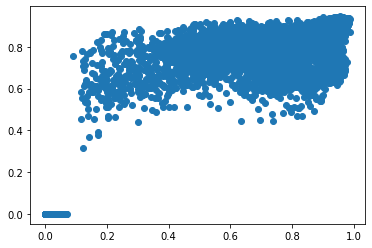

In [50]:
plt.scatter(x_view["search_rf_play_field_goal_made"], x_view["logit_advanced_play_field_goal_made"])

In [47]:
x_view[search_rf_play_class_names]

,search_rf_play_defensive_touchdown,search_rf_play_field_goal_made,search_rf_play_first_down,search_rf_play_none,search_rf_play_offensive_touchdown,search_rf_play_turnover
0,0.001985,2.118150e-07,0.180415,0.795288,0.007304,0.015007
1,0.002428,6.785287e-06,0.273053,0.699233,0.007378,0.017901
2,0.004831,5.230060e-06,0.348653,0.605294,0.009271,0.031946
3,0.001417,3.634286e-06,0.188023,0.786307,0.009668,0.014581
4,0.002085,1.254329e-05,0.292889,0.676476,0.009845,0.018692
...,...,...,...,...,...,...
523058,0.002267,8.142821e-05,0.221391,0.747861,0.008911,0.019488
523059,0.001914,1.521764e-04,0.602674,0.358675,0.017838,0.018746
523060,0.001978,7.010172e-06,0.626609,0.328941,0.021520,0.020944
523061,0.003169,3.275785e-04,0.619333,0.322870,0.022240,0.032061


In [52]:

log_loss_scores = {
    "play_outcome": {},
    "drive_outcome": {},
}
output_name = "play_outcome"
log_loss_scores[output_name]["naive"] = {
    "train": log_loss(x_view[x_view["season"]<2020][output_name], x_view[x_view["season"]<2020][naive_play_class_names]),
    "val": log_loss(x_view[x_view["season"]==2020][output_name], x_view[x_view["season"]==2020][naive_play_class_names]),
}
log_loss_scores[output_name]["logit_basic"] = {
    "train": log_loss(x_view[x_view["season"]<2020][output_name], x_view[x_view["season"]<2020][logit_play_basic_class_names]),
    "val": log_loss(x_view[x_view["season"]==2020][output_name], x_view[x_view["season"]==2020][logit_play_basic_class_names]),
}
log_loss_scores[output_name]["logit_advanced"] = {
    "train": log_loss(x_view[x_view["season"]<2020][output_name], x_view[x_view["season"]<2020][logit_play_advanced_class_names]),
    "val": log_loss(x_view[x_view["season"]==2020][output_name], x_view[x_view["season"]==2020][logit_play_advanced_class_names]),
}
log_loss_scores[output_name]["mlp"] = {
    "train": log_loss(x_view[x_view["season"]<2020][output_name], x_view[x_view["season"]<2020][mlp_play_class_names]),
    "val": log_loss(x_view[x_view["season"]==2020][output_name], x_view[x_view["season"]==2020][mlp_play_class_names]),
}
log_loss_scores[output_name]["rf"] = {
    "train": log_loss(x_view[x_view["season"]<2020][output_name], x_view[x_view["season"]<2020][rf_play_class_names]),
    "val": log_loss(x_view[x_view["season"]==2020][output_name], x_view[x_view["season"]==2020][rf_play_class_names]),
}
log_loss_scores[output_name]["search_rf"] = {
    "train": log_loss(x_view[x_view["season"]<2020][output_name], x_view[x_view["season"]<2020][search_rf_play_class_names]),
    "val": log_loss(x_view[x_view["season"]==2020][output_name], x_view[x_view["season"]==2020][search_rf_play_class_names]),
}
output_name = "drive_outcome_desc_basic"
log_loss_scores["drive_outcome"]["naive"] = {
    "train": log_loss(x_view[x_view["season"]<2020][output_name], x_view[x_view["season"]<2020][naive_drive_class_names]),
    "val": log_loss(x_view[x_view["season"]==2020][output_name], x_view[x_view["season"]==2020][naive_drive_class_names]),
}
log_loss_scores["drive_outcome"]["logit_basic"] = {
    "train": log_loss(x_view[x_view["season"]<2020][output_name], x_view[x_view["season"]<2020][logit_drive_basic_class_names]),
    "val": log_loss(x_view[x_view["season"]==2020][output_name], x_view[x_view["season"]==2020][logit_drive_basic_class_names]),
}
log_loss_scores["drive_outcome"]["logit_advanced"] = {
    "train": log_loss(x_view[x_view["season"]<2020][output_name], x_view[x_view["season"]<2020][logit_drive_advanced_class_names]),
    "val": log_loss(x_view[x_view["season"]==2020][output_name], x_view[x_view["season"]==2020][logit_drive_advanced_class_names]),
}
log_loss_scores["drive_outcome"]["mlp"] = {
    "train": log_loss(x_view[x_view["season"]<2020][output_name], x_view[x_view["season"]<2020][mlp_drive_class_names]),
    "val": log_loss(x_view[x_view["season"]==2020][output_name], x_view[x_view["season"]==2020][mlp_drive_class_names]),
}
log_loss_scores["drive_outcome"]["rf"] = {
    "train": log_loss(x_view[x_view["season"]<2020][output_name], x_view[x_view["season"]<2020][rf_drive_class_names]),
    "val": log_loss(x_view[x_view["season"]==2020][output_name], x_view[x_view["season"]==2020][rf_drive_class_names]),
}
log_loss_scores["play_outcomes_individual"] = {
    x: {
        "naive": {
            "train": log_loss(pd.get_dummies(x_view["play_outcome"])[x_view.season<2020][x], x_view[x_view.season<2020][x + "_naive"]),
            "val": log_loss(pd.get_dummies(x_view["play_outcome"])[x_view.season==2020][x], x_view[x_view.season==2020][x + "_naive"]),
        },
        "logit_basic": {
            "train": log_loss(pd.get_dummies(x_view["play_outcome"])[x_view.season<2020][x], x_view[x_view.season<2020]["logit_basic_play_" + x]),
            "val": log_loss(pd.get_dummies(x_view["play_outcome"])[x_view.season==2020][x], x_view[x_view.season==2020]["logit_basic_play_" + x]),
        },
        "logit_advanced": {
            "train": log_loss(pd.get_dummies(x_view["play_outcome"])[x_view.season<2020][x], x_view[x_view.season<2020]["logit_advanced_play_" + x]),
            "val": log_loss(pd.get_dummies(x_view["play_outcome"])[x_view.season==2020][x], x_view[x_view.season==2020]["logit_advanced_play_" + x]),
        },
        "mlp": {
            "train": log_loss(pd.get_dummies(x_view["play_outcome"])[x_view.season<2020][x], x_view[x_view.season<2020]["mlp_play_" + x]),
            "val": log_loss(pd.get_dummies(x_view["play_outcome"])[x_view.season==2020][x], x_view[x_view.season==2020]["mlp_play_" + x]),
        },
        "rf": {
            "train": log_loss(pd.get_dummies(x_view["play_outcome"])[x_view.season<2020][x], x_view[x_view.season<2020]["rf_play_" + x]),
            "val": log_loss(pd.get_dummies(x_view["play_outcome"])[x_view.season==2020][x], x_view[x_view.season==2020]["rf_play_" + x]),
        },        
        "search_rf": {
            "train": log_loss(pd.get_dummies(x_view["play_outcome"])[x_view.season<2020][x], x_view[x_view.season<2020]["search_rf_play_" + x]),
            "val": log_loss(pd.get_dummies(x_view["play_outcome"])[x_view.season==2020][x], x_view[x_view.season==2020]["search_rf_play_" + x]),
        },        
    } for x in x_view["play_outcome"].drop_duplicates().sort_values()
}
log_loss_scores["drive_outcomes_individual"] = {
    x: {
        "naive": {
            "train": log_loss(pd.get_dummies(x_view["drive_outcome_desc_basic"])[x_view.season<2020][x], x_view[x_view.season<2020][x + "_naive"]),
            "val": log_loss(pd.get_dummies(x_view["drive_outcome_desc_basic"])[x_view.season==2020][x], x_view[x_view.season==2020][x + "_naive"]),
        },
        "logit_basic": {
            "train": log_loss(pd.get_dummies(x_view["drive_outcome_desc_basic"])[x_view.season<2020][x], x_view[x_view.season<2020]["logit_basic_drive_" + x]),
            "val": log_loss(pd.get_dummies(x_view["drive_outcome_desc_basic"])[x_view.season==2020][x], x_view[x_view.season==2020]["logit_basic_drive_" + x]),
        },
        "logit_advanced": {
            "train": log_loss(pd.get_dummies(x_view["drive_outcome_desc_basic"])[x_view.season<2020][x], x_view[x_view.season<2020]["logit_advanced_drive_" + x]),
            "val": log_loss(pd.get_dummies(x_view["drive_outcome_desc_basic"])[x_view.season==2020][x], x_view[x_view.season==2020]["logit_advanced_drive_" + x]),
        },
        "mlp": {
            "train": log_loss(pd.get_dummies(x_view["drive_outcome_desc_basic"])[x_view.season<2020][x], x_view[x_view.season<2020]["mlp_drive_" + x]),
            "val": log_loss(pd.get_dummies(x_view["drive_outcome_desc_basic"])[x_view.season==2020][x], x_view[x_view.season==2020]["mlp_drive_" + x]),
        },
        "rf": {
            "train": log_loss(pd.get_dummies(x_view["drive_outcome_desc_basic"])[x_view.season<2020][x], x_view[x_view.season<2020]["rf_drive_" + x]),
            "val": log_loss(pd.get_dummies(x_view["drive_outcome_desc_basic"])[x_view.season==2020][x], x_view[x_view.season==2020]["rf_drive_" + x]),
        },        
    } for x in x_view["drive_outcome_desc_basic"].drop_duplicates().sort_values()
}
with open(os.path.join(data_dir, 'log_loss_scores_play_drive_predictions.json'), 'w') as f:
    json.dump(log_loss_scores, f)


In [109]:
brier_scores = {
    "play_outcomes_individual": {},
    "drive_outcomes_individual": {},
}

brier_scores["play_outcomes_individual"] = {
    x: {
        "naive": {
            "train": brier_score_loss(pd.get_dummies(x_view["play_outcome"])[x_view.season<2020][x], x_view[x_view.season<2020][x + "_naive"]),
            "val": brier_score_loss(pd.get_dummies(x_view["play_outcome"])[x_view.season==2020][x], x_view[x_view.season==2020][x + "_naive"]),
        },
        "logit_basic": {
            "train": brier_score_loss(pd.get_dummies(x_view["play_outcome"])[x_view.season<2020][x], x_view[x_view.season<2020]["logit_basic_play_" + x]),
            "val": brier_score_loss(pd.get_dummies(x_view["play_outcome"])[x_view.season==2020][x], x_view[x_view.season==2020]["logit_basic_play_" + x]),
        },
        "logit_advanced": {
            "train": brier_score_loss(pd.get_dummies(x_view["play_outcome"])[x_view.season<2020][x], x_view[x_view.season<2020]["logit_advanced_play_" + x]),
            "val": brier_score_loss(pd.get_dummies(x_view["play_outcome"])[x_view.season==2020][x], x_view[x_view.season==2020]["logit_advanced_play_" + x]),
        },
        "mlp": {
            "train": brier_score_loss(pd.get_dummies(x_view["play_outcome"])[x_view.season<2020][x], x_view[x_view.season<2020]["mlp_play_" + x]),
            "val": brier_score_loss(pd.get_dummies(x_view["play_outcome"])[x_view.season==2020][x], x_view[x_view.season==2020]["mlp_play_" + x]),
        },
        "rf": {
            "train": brier_score_loss(pd.get_dummies(x_view["play_outcome"])[x_view.season<2020][x], x_view[x_view.season<2020]["rf_play_" + x]),
            "val": brier_score_loss(pd.get_dummies(x_view["play_outcome"])[x_view.season==2020][x], x_view[x_view.season==2020]["rf_play_" + x]),
        },        
    } for x in x_view["play_outcome"].drop_duplicates().sort_values()
}
brier_scores["drive_outcomes_individual"] = {
    x: {
        "naive": {
            "train": brier_score_loss(pd.get_dummies(x_view["drive_outcome_desc_basic"])[x_view.season<2020][x], x_view[x_view.season<2020][x + "_naive"]),
            "val": brier_score_loss(pd.get_dummies(x_view["drive_outcome_desc_basic"])[x_view.season==2020][x], x_view[x_view.season==2020][x + "_naive"]),
        },
        "logit_basic": {
            "train": brier_score_loss(pd.get_dummies(x_view["drive_outcome_desc_basic"])[x_view.season<2020][x], x_view[x_view.season<2020]["logit_basic_drive_" + x]),
            "val": brier_score_loss(pd.get_dummies(x_view["drive_outcome_desc_basic"])[x_view.season==2020][x], x_view[x_view.season==2020]["logit_basic_drive_" + x]),
        },
        "logit_advanced": {
            "train": brier_score_loss(pd.get_dummies(x_view["drive_outcome_desc_basic"])[x_view.season<2020][x], x_view[x_view.season<2020]["logit_advanced_drive_" + x]),
            "val": brier_score_loss(pd.get_dummies(x_view["drive_outcome_desc_basic"])[x_view.season==2020][x], x_view[x_view.season==2020]["logit_advanced_drive_" + x]),
        },
        "mlp": {
            "train": brier_score_loss(pd.get_dummies(x_view["drive_outcome_desc_basic"])[x_view.season<2020][x], x_view[x_view.season<2020]["mlp_drive_" + x]),
            "val": brier_score_loss(pd.get_dummies(x_view["drive_outcome_desc_basic"])[x_view.season==2020][x], x_view[x_view.season==2020]["mlp_drive_" + x]),
        },
        "rf": {
            "train": brier_score_loss(pd.get_dummies(x_view["drive_outcome_desc_basic"])[x_view.season<2020][x], x_view[x_view.season<2020]["rf_drive_" + x]),
            "val": brier_score_loss(pd.get_dummies(x_view["drive_outcome_desc_basic"])[x_view.season==2020][x], x_view[x_view.season==2020]["rf_drive_" + x]),
        },        
    } for x in x_view["drive_outcome_desc_basic"].drop_duplicates().sort_values()
}
with open(os.path.join(data_dir, 'brier_scores_play_drive_predictions.json'), 'w') as f:
    json.dump(brier_scores, f)



In [ ]:
brier_scores["drive_outcomes_individual"]

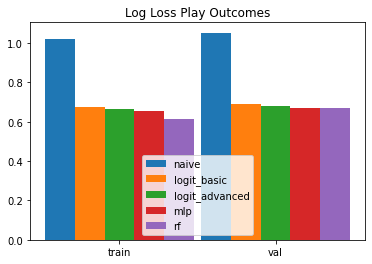

In [110]:
some_model_keys = ["naive", "logit_basic", "logit_advanced", "mlp", "rf"]
width = 1 / len(some_model_keys) - .01
play_outcome_bar = "offensive_touchdown"
i=1
for key in some_model_keys:
    bar_positions = np.arange(len(log_loss_scores["play_outcome"][key])) + i * width
    plt.bar(bar_positions, log_loss_scores["play_outcome"][key].values(), width=width)
    i+=1
plt.title("Log Loss Play Outcomes")
plt.xticks([width * i / 2, 1 + width * i / 2],["train", "val"])
# plt.xti()

# bar_col+=1

# fig.suptitle("Play Outcomes Log Loss Scores")
plt.legend(some_model_keys, loc="lower center")



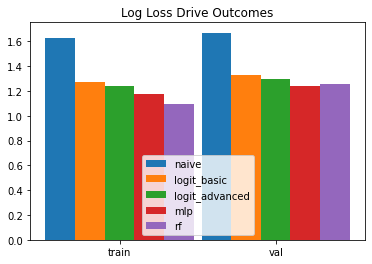

In [111]:
some_model_keys = ["naive", "logit_basic", "logit_advanced", "mlp", "rf"]
width = 1 / len(some_model_keys) - .01
i=1
for key in some_model_keys:
    bar_positions = np.arange(len(log_loss_scores["drive_outcome"][key])) + i * width
    plt.bar(bar_positions, log_loss_scores["drive_outcome"][key].values(), width=width)
    i+=1
plt.title("Log Loss Drive Outcomes")
plt.xticks([width * i / 2, 1 + width * i / 2],["train", "val"])
# plt.xti()

# bar_col+=1

# fig.suptitle("Play Outcomes Log Loss Scores")
plt.legend(some_model_keys, loc="lower center")



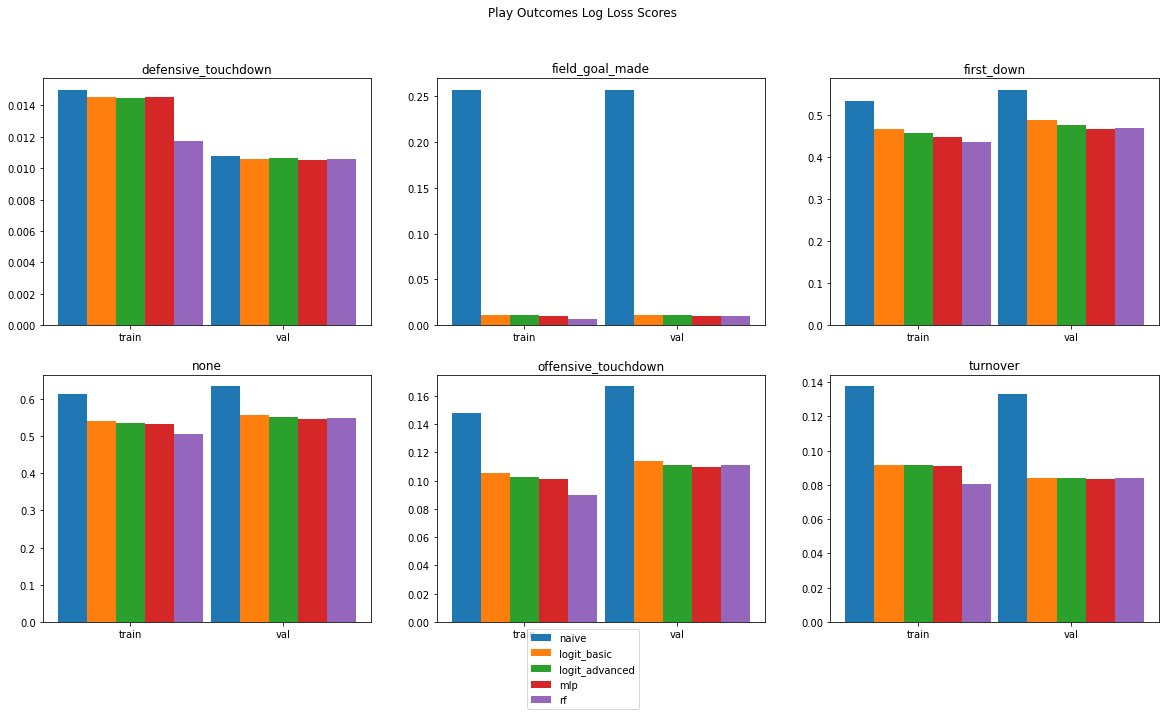

In [112]:
import math

some_model_keys = ["naive", "logit_basic", "logit_advanced", "mlp", "rf"]
width = 1 / len(some_model_keys) - .01
play_outcome_bar = "offensive_touchdown"
fig, ax = plt.subplots(2, math.ceil(len(log_loss_scores["play_outcomes_individual"])/2), figsize=(20, 10))
bar_col = 0
bar_row = 0
for play_outcome in log_loss_scores["play_outcomes_individual"].keys():
    i = 1
    if bar_col == math.ceil(len(log_loss_scores["play_outcomes_individual"])/2):
        bar_row+=1
        bar_col=0
    for key in some_model_keys:
        bar_positions = np.arange(len(log_loss_scores["play_outcomes_individual"][play_outcome][key])) + i * width
        ax[bar_row, bar_col].bar(bar_positions, log_loss_scores["play_outcomes_individual"][play_outcome][key].values(), width=width)
        i+=1
    ax[bar_row, bar_col].set_title(play_outcome)
    ax[bar_row, bar_col].set_xticks([width * i / 2, 1 + width * i / 2])
    ax[bar_row, bar_col].set_xticklabels(["train", "val"])

    bar_col+=1
    
fig.suptitle("Play Outcomes Log Loss Scores")
fig.legend(some_model_keys, loc="lower center")



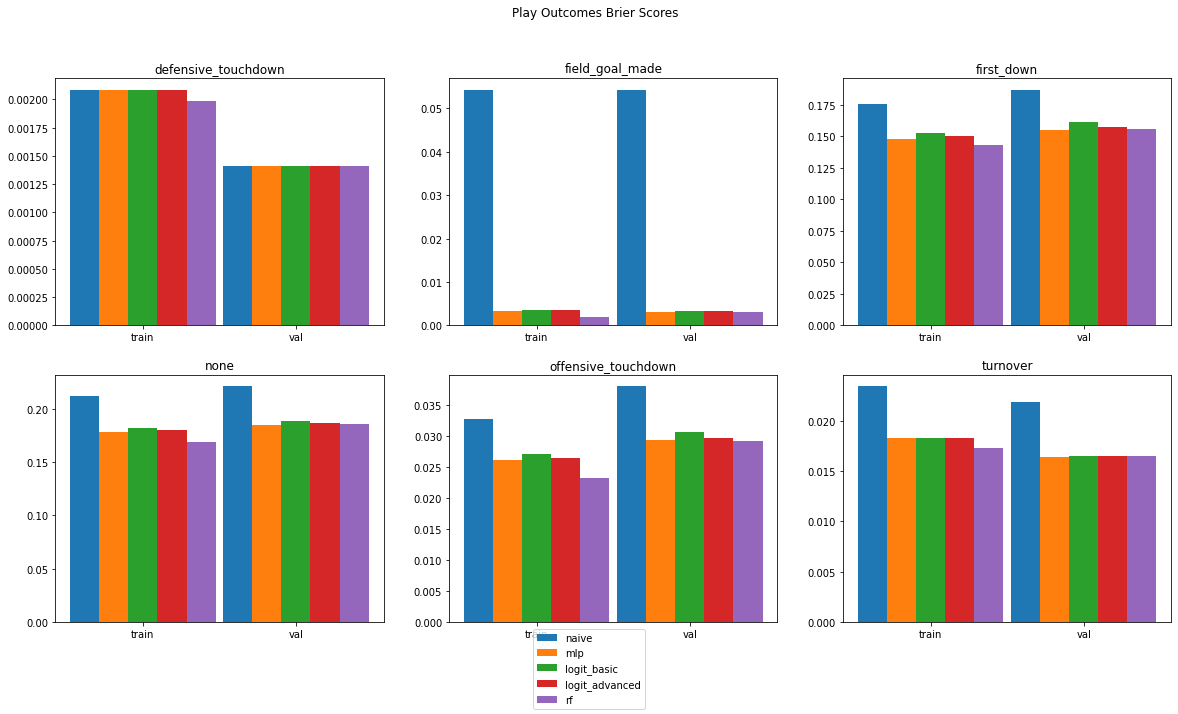

In [113]:
import math

some_model_keys = ["naive", "mlp", "logit_basic", "logit_advanced", "rf"]
width = 1 / len(some_model_keys) - .01
play_outcome_bar = "offensive_touchdown"
fig, ax = plt.subplots(2, math.ceil(len(brier_scores["play_outcomes_individual"])/2), figsize=(20, 10))
bar_col = 0
bar_row = 0
for play_outcome in brier_scores["play_outcomes_individual"].keys():
    i = 1
    if bar_col == math.ceil(len(brier_scores["play_outcomes_individual"])/2):
        bar_row+=1
        bar_col=0
    for key in some_model_keys:
        bar_positions = np.arange(len(brier_scores["play_outcomes_individual"][play_outcome][key])) + i * width
        ax[bar_row, bar_col].bar(bar_positions, brier_scores["play_outcomes_individual"][play_outcome][key].values(), width=width)
        i+=1
    ax[bar_row, bar_col].set_title(play_outcome)
    ax[bar_row, bar_col].set_xticks([width * i / 2, 1 + width * i / 2])
    ax[bar_row, bar_col].set_xticklabels(["train", "val"])

    bar_col+=1
# ax[0, 0].set_ylim([0.0014115, 0.001414])
fig.suptitle("Play Outcomes Brier Scores")
fig.legend(some_model_keys, loc="lower center")


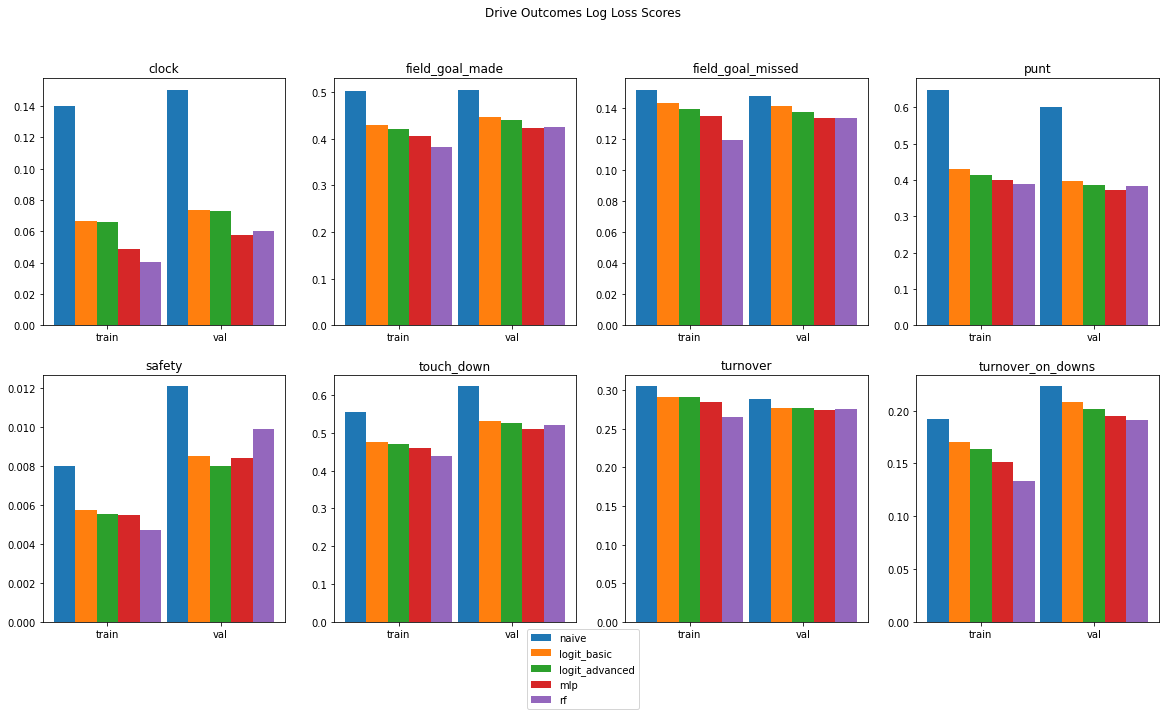

In [114]:
import math

some_model_keys = ["naive", "logit_basic", "logit_advanced", "mlp", "rf"]
width = 1 / len(some_model_keys) - .01
drive_outcome_bar = "offensive_touchdown"
fig, ax = plt.subplots(2, math.ceil(len(log_loss_scores["drive_outcomes_individual"])/2), figsize=(20, 10))
bar_col = 0
bar_row = 0
for drive_outcome in log_loss_scores["drive_outcomes_individual"].keys():
    i = 1
    if bar_col == math.ceil(len(log_loss_scores["drive_outcomes_individual"])/2):
        bar_row+=1
        bar_col=0
    for key in some_model_keys:
        bar_positions = np.arange(len(log_loss_scores["drive_outcomes_individual"][drive_outcome][key])) + i * width
        ax[bar_row, bar_col].bar(bar_positions, log_loss_scores["drive_outcomes_individual"][drive_outcome][key].values(), width=width)
        i+=1
    ax[bar_row, bar_col].set_title(drive_outcome)
    ax[bar_row, bar_col].set_xticks([width * i / 2, 1 + width * i / 2])
    ax[bar_row, bar_col].set_xticklabels(["train", "val"])

    bar_col+=1
    
fig.suptitle("Drive Outcomes Log Loss Scores")
fig.legend(some_model_keys, loc="lower center")




5


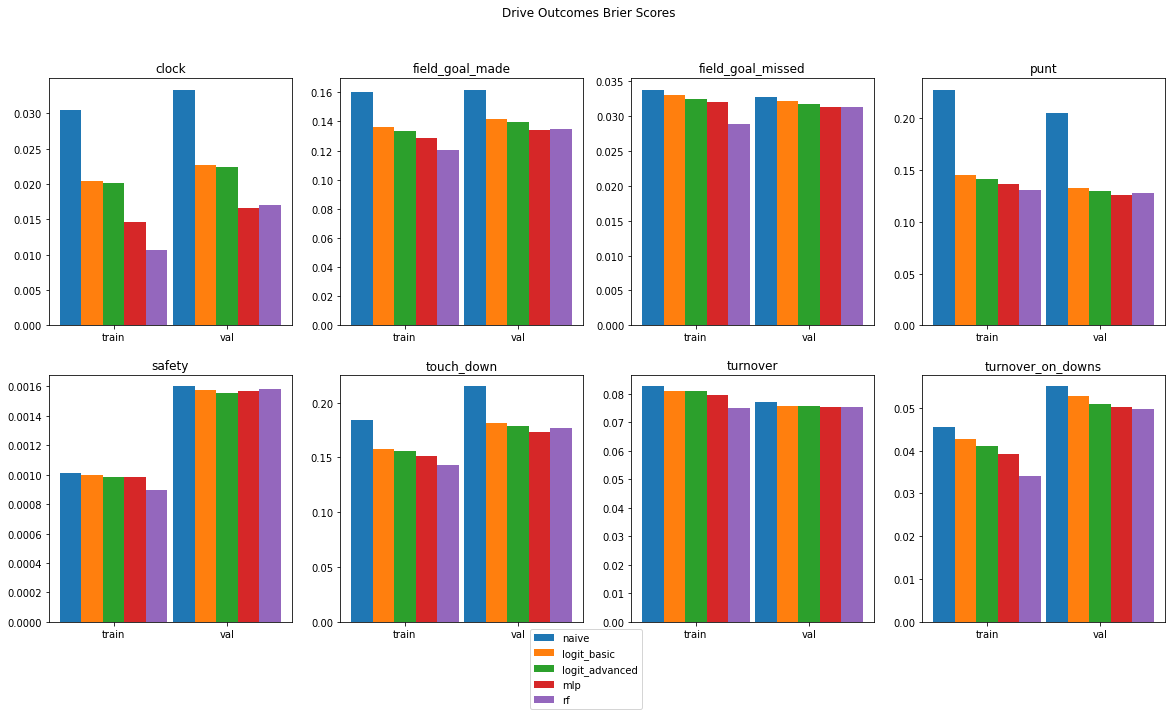

In [115]:
import math
print(int(math.ceil(4.2)))
some_model_keys = ["naive", "logit_basic", "logit_advanced", "mlp", "rf"]
width = 1 / len(some_model_keys) - .01
drive_outcome_bar = "offensive_touchdown"
fig, ax = plt.subplots(2, math.ceil(len(brier_scores["drive_outcomes_individual"])/2), figsize=(20, 10))
bar_col = 0
bar_row = 0
for drive_outcome in brier_scores["drive_outcomes_individual"].keys():
    i = 1
    if bar_col == math.ceil(len(brier_scores["drive_outcomes_individual"])/2):
        bar_row+=1
        bar_col=0
    for key in some_model_keys:
        bar_positions = np.arange(len(brier_scores["drive_outcomes_individual"][drive_outcome][key])) + i * width
        ax[bar_row, bar_col].bar(bar_positions, brier_scores["drive_outcomes_individual"][drive_outcome][key].values(), width=width)
        i+=1
    ax[bar_row, bar_col].set_title(drive_outcome)
    ax[bar_row, bar_col].set_xticks([width * i / 2, 1 + width * i / 2])
    ax[bar_row, bar_col].set_xticklabels(["train", "val"])

    bar_col+=1
    
fig.suptitle("Drive Outcomes Brier Scores")
fig.legend(some_model_keys, loc="lower center")



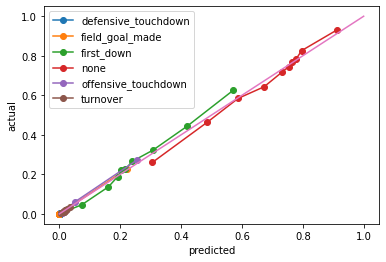

In [116]:
output_name = "play_outcome"

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

output_one_hot = enc.fit(x_view[[output_name]])

x_view[enc.categories_[0]] = pd.DataFrame(enc.transform(x_view[[output_name]]).toarray(), columns=enc.categories_[0])

calb_df = x_view[x_view["season"]==2020]
for x in enc.categories_[0]:
    calb = calibration.calibration_curve(calb_df[x], calb_df["rf_play_"+x], n_bins=10, strategy="quantile")
    plt.plot(calb[1], calb[0], marker = "o", label=x)


plt.xlabel("predicted")
plt.ylabel("actual")
plt.legend()
plt.plot([0, 1], [0, 1])

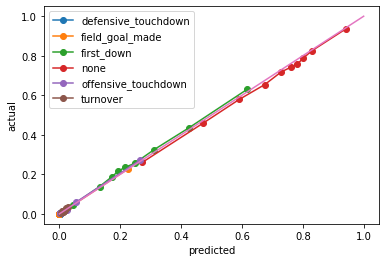

In [117]:
output_name = "play_outcome"

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

output_one_hot = enc.fit(x_view[[output_name]])

x_view[enc.categories_[0]] = pd.DataFrame(enc.transform(x_view[[output_name]]).toarray(), columns=enc.categories_[0])

calb_df = x_view[x_view["season"]==2020]
for x in enc.categories_[0]:
    calb = calibration.calibration_curve(calb_df[x], calb_df["mlp_play_"+x], n_bins=10, strategy="quantile")
    plt.plot(calb[1], calb[0], marker = "o", label=x)


plt.xlabel("predicted")
plt.ylabel("actual")
plt.legend()
plt.plot([0, 1], [0, 1])

In [ ]:
output_name = "drive_outcome_desc_basic"

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

output_one_hot = enc.fit(x_view[[output_name]])

x_view[enc.categories_[0]] = pd.DataFrame(enc.transform(x_view[[output_name]]).toarray(), columns=enc.categories_[0])

calb_df = x_view[x_view["season"]<2020]
for x in enc.categories_[0]:
    calb = calibration.calibration_curve(calb_df[x], calb_df["rf_drive_"+x], n_bins=5, strategy="quantile")
    plt.plot(calb[1], calb[0], marker = "o", label=x)


plt.xlabel("predicted")
plt.ylabel("actual")
plt.legend()
plt.plot([0, 1], [0, 1])

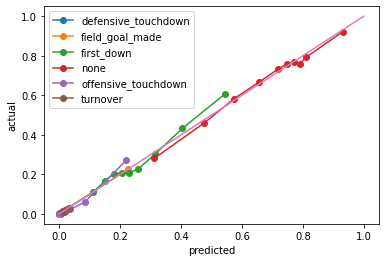

In [121]:
output_name = "play_outcome"

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

output_one_hot = enc.fit(x_view[[output_name]])

x_view[enc.categories_[0]] = pd.DataFrame(enc.transform(x_view[[output_name]]).toarray(), columns=enc.categories_[0])

calb_df = x_view[x_view["season"]==2020]
for x in enc.categories_[0]:
    calb = calibration.calibration_curve(calb_df[x], calb_df["logit_basic_play_"+x], n_bins=10, strategy="quantile")
    plt.plot(calb[1], calb[0], marker = "o", label=x)


plt.xlabel("predicted")
plt.ylabel("actual")
plt.legend()
plt.plot([0, 1], [0, 1])

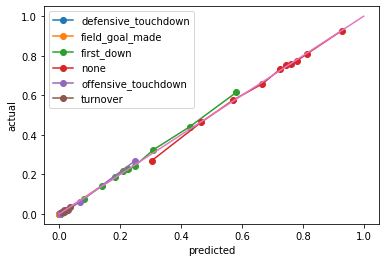

In [122]:
output_name = "play_outcome"

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

output_one_hot = enc.fit(x_view[[output_name]])

x_view[enc.categories_[0]] = pd.DataFrame(enc.transform(x_view[[output_name]]).toarray(), columns=enc.categories_[0])

calb_df = x_view[x_view["season"]==2020]
for x in enc.categories_[0]:
    calb = calibration.calibration_curve(calb_df[x], calb_df["logit_advanced_play_"+x], n_bins=10, strategy="quantile")
    plt.plot(calb[1], calb[0], marker = "o", label=x)


plt.xlabel("predicted")
plt.ylabel("actual")
plt.legend()
plt.plot([0, 1], [0, 1])

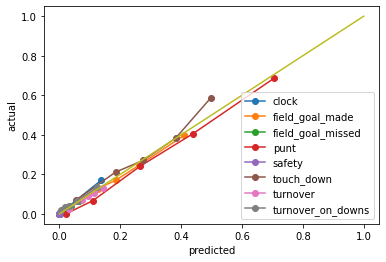

In [128]:
output_name = "drive_outcome_desc_basic"

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

output_one_hot = enc.fit(x_view[[output_name]])

x_view[enc.categories_[0]] = pd.DataFrame(enc.transform(x_view[[output_name]]).toarray(), columns=enc.categories_[0])

calb_df = x_view[x_view["season"]==2020]
for x in enc.categories_[0]:
    calb = calibration.calibration_curve(calb_df[x], calb_df["logit_basic_drive_"+x], n_bins=5, strategy="quantile")
    plt.plot(calb[1], calb[0], marker = "o", label=x)


plt.xlabel("predicted")
plt.ylabel("actual")
plt.legend()
plt.plot([0, 1], [0, 1])

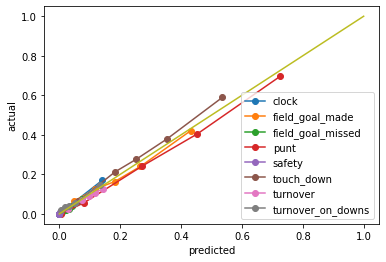

In [129]:
output_name = "drive_outcome_desc_basic"

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

output_one_hot = enc.fit(x_view[[output_name]])

x_view[enc.categories_[0]] = pd.DataFrame(enc.transform(x_view[[output_name]]).toarray(), columns=enc.categories_[0])

calb_df = x_view[x_view["season"]==2020]
for x in enc.categories_[0]:
    calb = calibration.calibration_curve(calb_df[x], calb_df["logit_advanced_drive_"+x], n_bins=5, strategy="quantile")
    plt.plot(calb[1], calb[0], marker = "o", label=x)


plt.xlabel("predicted")
plt.ylabel("actual")
plt.legend()
plt.plot([0, 1], [0, 1])

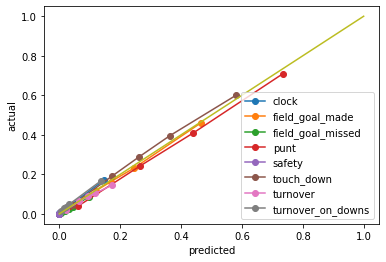

In [123]:
output_name = "drive_outcome_desc_basic"

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

output_one_hot = enc.fit(x_view[[output_name]])

x_view[enc.categories_[0]] = pd.DataFrame(enc.transform(x_view[[output_name]]).toarray(), columns=enc.categories_[0])

calb_df = x_view[x_view["season"]==2020]
for x in enc.categories_[0]:
    calb = calibration.calibration_curve(calb_df[x], calb_df["mlp_drive_"+x], n_bins=5, strategy="quantile")
    plt.plot(calb[1], calb[0], marker = "o", label=x)


plt.xlabel("predicted")
plt.ylabel("actual")
plt.legend()
plt.plot([0, 1], [0, 1])

In [130]:
pred_output_rf_play = rf_play_outcome.predict_proba(pd.DataFrame(X_train.iloc[0:1, :], columns = input_names))
[round(x, 4) for x in pred_output_rf_play[0]]
np.array([round(x, 4) for x in pred_output_rf_play[0]])
pd.DataFrame([[round(x, 4) for x in pred_output_rf_play[0]]], columns=mlp_play_outcome.classes_)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
input_names_advanced

In [139]:
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
rf_drive_outcome.verbose=0
rf_play_outcome.verbose=0

def plot_model_probabilities(model, input_feature, input_feature_advance):
    fig, axs = plt.subplots(1, 1, figsize=(15,5)) 
    pred_output_logit_basic_play = logit_play_outcome_basic.predict_proba(pd.DataFrame(input_feature, columns = input_names))
    pred_output_logit_advanced_play = logit_play_outcome_advanced.predict_proba(pd.DataFrame(input_feature_advance, columns = input_names_advanced))
    pred_output_logit_basic_drive = logit_drive_outcome_basic.predict_proba(pd.DataFrame(input_feature, columns = input_names))
    pred_output_logit_advanced_drive = logit_drive_outcome_advanced.predict_proba(pd.DataFrame(input_feature_advance, columns = input_names_advanced))
    pred_output_mlp_play = mlp_play_outcome.predict_proba(pd.DataFrame(input_feature, columns = input_names))
    pred_output_mlp_drive = mlp_drive_outcome.predict_proba(pd.DataFrame(input_feature, columns = input_names))
    pred_output_rf_play = rf_play_outcome.predict_proba(pd.DataFrame(input_feature, columns = input_names))
    pred_output_rf_drive = rf_drive_outcome.predict_proba(pd.DataFrame(input_feature, columns = input_names))
    # print(pd.DataFrame(input_feature, columns = input_names))
    if model == "mlp_play":
        # np.set_printoptions(suppress=True,linewidth=np.nan)
        # print(pd.DataFrame([[round(x, 6) for x in pred_output_mlp_play[0]]], columns=mlp_play_outcome.classes_).T)
        axs.bar(mlp_play_outcome.classes_, pred_output_mlp_play[0])
    elif model == "rf_play":
        # print(pd.DataFrame([[round(x, 6) for x in pred_output_rf_play[0]]], columns=rf_play_outcome.classes_).T)
        axs.bar(rf_play_outcome.classes_, pred_output_rf_play[0])
    elif model == "logit_basic_play":
        # print(pd.DataFrame([[round(x, 6) for x in pred_output_logit_basic_play[0]]], columns=logit_play_outcome_basic.classes_).T)
        axs.bar(logit_play_outcome_basic.classes_, pred_output_logit_basic_play[0])
    elif model == "logit_basic_drive":
        # print(pd.DataFrame([[round(x, 6) for x in pred_output_logit_basic_drive[0]]], columns=logit_drive_outcome_basic.classes_).T)
        axs.bar(logit_drive_outcome_basic.classes_, pred_output_logit_basic_drive[0])
    elif model == "logit_advanced_play":
        # print(pd.DataFrame([[round(x, 6) for x in pred_output_logit_advanced_play[0]]], columns=logit_play_outcome_advanced.classes_).T)
        axs.bar(logit_play_outcome_advanced.classes_, pred_output_logit_advanced_play[0])
    elif model == "logit_advanced_drive":
        # print(pd.DataFrame([[round(x, 6) for x in pred_output_logit_advanced_drive[0]]], columns=logit_drive_outcome_advanced.classes_).T)
        axs.bar(logit_drive_outcome_advanced.classes_, pred_output_logit_advanced_drive[0])
    elif model == "mlp_drive":
        # print(pd.DataFrame([[round(x, 6) for x in pred_output_mlp_drive[0]]], columns=mlp_drive_outcome.classes_))
        axs.bar(mlp_drive_outcome.classes_, pred_output_mlp_drive[0])
    elif model == "rf_drive":
        # print(pd.DataFrame([[round(x, 6) for x in pred_output_rf_drive[0]]], columns=rf_drive_outcome.classes_))
        axs.bar(rf_drive_outcome.classes_, pred_output_rf_drive[0])

    play_outcome_matrix = pd.concat([
        pd.DataFrame([[round(x, 6) for x in pred_output_logit_basic_play[0]]], columns=logit_play_outcome_basic.classes_, index=["logit_basic"]).T,
        pd.DataFrame([[round(x, 6) for x in pred_output_logit_advanced_play[0]]], columns=logit_play_outcome_advanced.classes_, index=["logit_advanced"]).T,
        pd.DataFrame([[round(x, 6) for x in pred_output_mlp_play[0]]], columns=mlp_play_outcome.classes_, index=["mlp"]).T,
        pd.DataFrame([[round(x, 6) for x in pred_output_rf_play[0]]], columns=rf_play_outcome.classes_, index=["rf"]).T,
    ], axis=1)
    drive_outcome_matrix = pd.concat([
        pd.DataFrame([[round(x, 6) for x in pred_output_logit_basic_drive[0]]], columns=logit_drive_outcome_basic.classes_, index=["logit_basic"]).T,
        pd.DataFrame([[round(x, 6) for x in pred_output_logit_advanced_drive[0]]], columns=logit_drive_outcome_advanced.classes_, index=["logit_advanced"]).T,
        pd.DataFrame([[round(x, 6) for x in pred_output_mlp_drive[0]]], columns=mlp_drive_outcome.classes_, index=["mlp"]).T,
        pd.DataFrame([[round(x, 6) for x in pred_output_rf_drive[0]]], columns=rf_drive_outcome.classes_, index=["rf"]).T,
    ], axis=1)

    print(play_outcome_matrix)
    print(drive_outcome_matrix)
    axs.set_ylim([0, 1])
    axs.set_yticks(np.arange(0, 1.1, .1))
    axs.grid(axis="y")
    plt.savefig("example.png")

style = {'description_width': '200px'}
layout = Layout(width='450px')
@interact(
    time_left_in_half=widgets.IntSlider(min=0, max=30, step=1, value=100, style=style, layout=layout),
    half=widgets.IntSlider(min=1, max=2, step=1, value=1, style=style, layout=layout),
    current_score_diff=widgets.IntSlider(min=-30, max=30, step=1, value=0, style=style, layout=layout),
    current_score_total=widgets.IntSlider(min=0, max=80, step=1, value=0, style=style, layout=layout),
    cur_spread=widgets.IntSlider(min=-20, max=20, step=1, value=-3, style=style, layout=layout),
    cur_over_under=widgets.IntSlider(min=30, max=60, step=1, value=45, style=style, layout=layout),
    home_timeouts_remaining=widgets.IntSlider(min=0, max=3, step=1, value=3, style=style, layout=layout),
    away_timeouts_remaining=widgets.IntSlider(min=0, max=3, step=1, value=3, style=style, layout=layout),
    ytg=widgets.IntSlider(min=1, max=30, step=1, value=10, style=style, layout=layout),
    yd_from_goal=widgets.IntSlider(min=1, max=100, step=1, value=75, style=style, layout=layout),
    down=widgets.IntSlider(min=1, max=4, step=1, value=1, style=style, layout=layout),
    model=widgets.Dropdown(options=["logit_basic_play", "logit_basic_drive", "logit_advanced_play", "logit_advanced_drive", "mlp_play", "mlp_drive", "rf_play", "rf_drive"], value="mlp_play"),
    punt=False,
    field_goal_attempt=False,
    home_team_has_ball=True,
)
def g(
    time_left_in_half,
    half,
    current_score_diff,
    current_score_total,
    cur_spread,
    cur_over_under,
    home_timeouts_remaining,
    away_timeouts_remaining,
    ytg,
    yd_from_goal,
    down,
    punt,
    field_goal_attempt,
    home_team_has_ball,
    model
):
    ytg_adj = np.where(yd_from_goal < ytg, yd_from_goal, ytg)
    input_feature = pd.DataFrame(np.array(
        [
            time_left_in_half * 60,
            half,
            current_score_diff,
            current_score_total,
            cur_spread,
            cur_over_under,
            home_timeouts_remaining,
            away_timeouts_remaining,
            punt,
            field_goal_attempt,
            ytg_adj,
            yd_from_goal,
            down,
            home_team_has_ball,
        ],
    ).reshape(1, -1), columns=input_names)
    input_feature = normalize_df(input_feature, model_df[mask_model][input_names])
    print(input_feature)

    input_feature_advance = pd.DataFrame(np.array(
        [
            time_left_in_half * 60,
            (time_left_in_half * 60)**2,
            half,
            current_score_diff,
            current_score_total,
            cur_spread,
            cur_over_under,
            home_timeouts_remaining,
            away_timeouts_remaining,
            punt,
            field_goal_attempt,
            home_team_has_ball,
            np.where(down==2, 1, 0),
            np.where(down==3, 1, 0),
            np.where(down==4, 1, 0),
            np.where(down==1, ytg_adj, 0),
            np.where(down==2, ytg_adj, 0),
            np.where(down==3, ytg_adj, 0),
            np.where(down==4, ytg_adj, 0),
            np.where(down==1, yd_from_goal, 0),
            np.where(down==2, yd_from_goal, 0),
            np.where(down==3, yd_from_goal, 0),
            np.where(down==4, yd_from_goal, 0),
            np.where(down==1, ytg_adj, 0)**2,
            np.where(down==2, ytg_adj, 0)**2,
            np.where(down==3, ytg_adj, 0)**2,
            np.where(down==4, ytg_adj, 0)**2,
            np.where(down==1, yd_from_goal, 0)**2,
            np.where(down==2, yd_from_goal, 0)**2,
            np.where(down==3, yd_from_goal, 0)**2,
            np.where(down==4, yd_from_goal, 0)**2,
        ],
    ).reshape(1, -1), columns=input_names_advanced)
    input_feature_advance = normalize_df(input_feature_advance, model_df[mask_model][input_names_advanced])

    # print(pd.DataFrame(input_feature, columns=mlp_play_outcome.feature_names_in_))
    plot_model_probabilities(model, input_feature, input_feature_advance)
    

interactive(children=(IntSlider(value=30, description='time_left_in_half', layout=Layout(width='450px'), max=3…

In [ ]:
normalize_df(model_df[mask_model][input_names],model_df[mask_model][input_names])

In [ ]:
input_feature = [300, 1]
   
pd.DataFrame(input_feature)

In [ ]:
input_names_advanced

In [ ]:
import itertools as it


play_possibilities = {
    "time_left_in_half": [1800],
    "half": [1],
    "current_score_diff": [0],
    "current_score_total": [0],
    "cur_spread": [-3],
    "cur_over_under": [45],
    "home_timeouts_remaining": [3],
    "away_timeouts_remaining": [3],
    "ytg": range(1, 11),
    "yd_from_goal": range(1, 101),
    "down": range(1, 5),
    "punt": [0],
    "field_goal_attempt": [0],
    "home_team_has_ball": [1],
}

play_possibilities_df = pd.DataFrame(it.product(*(play_possibilities[Name] for Name in play_possibilities)), columns=play_possibilities)

play_possibilities_df[mlp_play_class_names] = mlp_play_outcome.predict_proba(play_possibilities_df[input_names])
play_possibilities_df[mlp_drive_class_names] = mlp_drive_outcome.predict_proba(play_possibilities_df[input_names])
play_possibilities_df[rf_play_class_names] = rf_play_outcome.predict_proba(play_possibilities_df[input_names])
play_possibilities_df[rf_drive_class_names] = rf_drive_outcome.predict_proba(play_possibilities_df[input_names])
print(mlp_drive_class_names, mlp_play_class_names)
for ytg in range(1, 5):
    plot_input = play_possibilities_df[
        (play_possibilities_df.ytg == 10) &
        # (play_possibilities_df.yd_from_goal == ytg * 10)&
        (play_possibilities_df.down == ytg)
    ]
    plt.plot(plot_input["yd_from_goal"], plot_input["rf_drive_TD"], label=ytg)
    plt.ylim([0, 1])
    plt.legend()

In [ ]:
plot_input

In [ ]:
event_df[(event_df["field_goal_attempt"]==1)&event_df["touchdown_in_drive"]==1]

In [ ]:
test = event_df
all_play_drive_predictions = rf_play_class_names + mlp_play_class_names + rf_drive_class_names + mlp_drive_class_names
test[all_play_drive_predictions] = test.merge(x_view[["index"] + all_play_drive_predictions], how="left", left_index=True, right_on="index")[all_play_drive_predictions]
test

In [ ]:
event_df[all_play_drive_predictions] = event_df[all_play_drive_predictions].fillna(0)

In [ ]:
# game_df = event_df.groupby(["game_code"], as_index=False).max()[["game_code", "quarter"]]
# event_df["end_of_regulation_score_diff"] = np.where(event_df.merge(game_df, on="game_code", how="left")["quarter_y"]>4, 0, event_df["final_score_diff"])

In [ ]:
from sklearn.model_selection import GridSearchCV
max_away_score = np.max(event_df["away_final_score"])
max_home_score = np.max(event_df["home_final_score"])

event_df["cur_spread"].fillna((event_df["cur_spread"].mean()), inplace=True)
event_df["cur_over_under"].fillna((event_df["cur_over_under"].mean()), inplace=True)
event_df['remaining_exact_score'] = event_df["away_rest_of_game_score"] + (max_away_score + 1) * event_df['home_rest_of_game_score']
# event_df['remaining_score_diff_change'] = event_df["final_score_diff"] - event_df["current_score_diff"]
# event_df['end_of_regulation_score_diff_change'] = event_df["end_of_regulation_score_diff"] - event_df["current_score_diff"]


mask_train = (event_df.season<=2019)&(event_df.continuation==0)&(event_df.overtime==0)
mask_test = (event_df.season==2021)&(event_df.continuation==0)&(event_df.overtime==0)
mask_val = (event_df.season==2020)&(event_df.continuation==0)&(event_df.overtime==0)
train_groups = event_df[mask_train]["game_code"]
# event_df["home_odds_fixed"] = event_df["home_odds"].fillna(np.mean(event_df["home_odds"]))
input_names_vegas_mlp_score_predictor = ["time_left_in_game", "current_score_diff", "current_score_total", "cur_spread", "cur_over_under", 'home_timeouts_remaining', 'away_timeouts_remaining']
output_name_score_diff = "end_of_regulation_score_diff_change"
score_change_columns = [
    "rf_play_offensive_touchdown",
    "rf_drive_offensive_touchdown",
    "rf_play_turnover",
    "rf_drive_turnover",
]

model_df = deepcopy(event_df[input_names_vegas_mlp_score_predictor + score_change_columns + ['kick_off', 'season', 'game_code', 'punt', 'point_after_kick', 'continuation', 'two_point_attempt', 'field_goal_attempt', output_name_score_diff]])
model_df["from_scrimmage"] = np.where(event_df["event_id"].isin([22, 52, 53, 55, 47, 54, 56]), 0, event_df["from_scrimmage"])
model_df["ytg"] = np.where(model_df["from_scrimmage"] == 0, -1, event_df["ytg"])
model_df["down"] = np.where(model_df["from_scrimmage"] == 0, 0, event_df["down"])
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(model_df[["down"]])
down_one_hot_cols = ["down_" + str(x) for x in enc.categories_[0]]
model_df[down_one_hot_cols] = pd.DataFrame(enc.transform(model_df[["down"]]).toarray(), columns=enc.categories_)

model_df["home_team_has_ball"] = np.where(event_df["event_id"].isin([5]), 1 - event_df["home_team_has_ball"], event_df["home_team_has_ball"])
model_df["yd_from_goal"] = np.where(model_df["from_scrimmage"] == 0, -1, event_df["yd_from_goal"])
input_names_vegas_mlp_score_diff=[
    'time_left_in_game',
    'current_score_diff',
    'current_score_total',
    'cur_spread',
    'cur_over_under',
    'home_timeouts_remaining',
    'away_timeouts_remaining',
    'kick_off',
    'punt',
    'point_after_kick',
    'two_point_attempt',
    'field_goal_attempt',
    # 'from_scrimmage',
    'ytg',
    'yd_from_goal',
    'down',
    'home_team_has_ball'
 ] + score_change_columns
mask_model = (model_df[input_names_vegas_mlp_score_diff+[output_name_score_diff]].notna().all(axis=1))&(event_df["overtime"]==0)
X_train, y_train, group_train, X_test, y_test, group_test, X_val, y_val, group_val = create_train_test_val_df(model_df[mask_model], input_names_vegas_mlp_score_diff, output_name_score_diff)


mlp_score_diff = MLPClassifier(hidden_layer_sizes=[100], verbose=True, random_state=1, early_stopping=True, n_iter_no_change=5)
mlp_score_diff.fit(X_train.values, y_train)
rf_score_diff = RandomForestClassifier(n_estimators=500, max_depth=15, verbose=1, n_jobs=-1)
rf_score_diff.fit(X_train, y_train)


In [ ]:
model_df = deepcopy(event_df[input_names_vegas_mlp_score_predictor + score_change_columns + ['kick_off', 'season', 'game_code', 'punt', 'point_after_kick', 'continuation', 'two_point_attempt', 'field_goal_attempt', output_name_score_diff]])
model_df["from_scrimmage"] = np.where(event_df["event_id"].isin([22, 52, 53, 55, 47, 54, 56]), 0, event_df["from_scrimmage"])
model_df["ytg"] = np.where(model_df["from_scrimmage"] == 0, -1, event_df["ytg"])
model_df["down"] = np.where(model_df["from_scrimmage"] == 0, 0, event_df["down"])
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(model_df[["down"]])
down_one_hot_cols = ["down_" + str(x) for x in enc.categories_[0]]
model_df[down_one_hot_cols] = pd.DataFrame(enc.transform(model_df[["down"]]).toarray(), columns=enc.categories_)

model_df["home_team_has_ball"] = np.where(event_df["event_id"].isin([5]), 1 - event_df["home_team_has_ball"], event_df["home_team_has_ball"])
model_df["yd_from_goal"] = np.where(model_df["from_scrimmage"] == 0, -1, event_df["yd_from_goal"])
input_names_vegas_mlp_score_diff=[
    'time_left_in_game',
    'current_score_diff',
    'current_score_total',
    'cur_spread',
    'cur_over_under',
    'home_timeouts_remaining',
    'away_timeouts_remaining',
    'kick_off',
    'punt',
    'point_after_kick',
    'two_point_attempt',
    'field_goal_attempt',
    # 'from_scrimmage',
    'ytg',
    'yd_from_goal',
    'down',
    'home_team_has_ball'
 ] + score_change_columns
# model_df = model_df[(model_df[input_names_vegas_mlp_score_diff+[output_name_score_diff]].notna().all(axis=1))&(event_df["overtime"]==0)]

model_df

In [ ]:
event_df["xhome_win_score_diff_mlp"]

In [ ]:
score_diff_preds = mlp_score_diff.predict_proba(model_df[input_names_vegas_mlp_score_diff].fillna(0))
score_diff_change_list = mlp_score_diff.classes_
score_probability_matrix = np.zeros((score_diff_preds.shape))
outcomes_dict = {
    "xhome_win": {},
    "xdraw": {},
    "xaway_win": {},
    "xscore_diff_end_of_regulation": {},
}
for x in range(len(event_df)):
    if round(x/100000) == x/100000:
        print(x)
    score_probability_matrix[x] = event_df["current_score_diff"][x] + score_diff_change_list
    outcomes_dict["xhome_win"][x] = np.sum(score_diff_preds[x][score_probability_matrix[x]>0])
    outcomes_dict["xdraw"][x] = np.sum(score_diff_preds[x][score_probability_matrix[x]==0])
    outcomes_dict["xaway_win"][x] = np.sum(score_diff_preds[x][score_probability_matrix[x]<0])
    outcomes_dict["xscore_diff_end_of_regulation"][x] = np.sum(score_probability_matrix[x] * score_diff_preds[x])

event_df["xhome_win_score_diff_mlp"] = outcomes_dict["xhome_win"].values()
event_df["xdraw_score_diff_mlp"] = outcomes_dict["xdraw"].values()
event_df["xaway_win_score_diff_mlp"] = outcomes_dict["xaway_win"].values()
event_df["xscore_diff_end_of_regulation_mlp"] = outcomes_dict["xscore_diff_end_of_regulation"].values()


In [ ]:

score_diff_preds = rf_score_diff.predict_proba(model_df[input_names_vegas_mlp_score_diff].fillna(0))
score_diff_change_list = rf_score_diff.classes_
score_probability_matrix = np.zeros((score_diff_preds.shape))
outcomes_dict = {
    "xhome_win": {},
    "xdraw": {},
    "xaway_win": {},
    "xscore_diff_end_of_regulation": {},
}
for x in range(len(event_df)):
    if round(x/100000) == x/100000:
        print(x)
    score_probability_matrix[x] = event_df["current_score_diff"][x] + score_diff_change_list
    outcomes_dict["xhome_win"][x] = np.sum(score_diff_preds[x][score_probability_matrix[x]>0])
    outcomes_dict["xdraw"][x] = np.sum(score_diff_preds[x][score_probability_matrix[x]==0])
    outcomes_dict["xaway_win"][x] = np.sum(score_diff_preds[x][score_probability_matrix[x]<0])
    outcomes_dict["xscore_diff_end_of_regulation"][x] = np.sum(score_probability_matrix[x] * score_diff_preds[x])
event_df["xhome_win_score_diff_rf"] = outcomes_dict["xhome_win"].values()
event_df["xdraw_score_diff_rf"] = outcomes_dict["xdraw"].values()
event_df["xaway_win_score_diff_rf"] = outcomes_dict["xaway_win"].values()
event_df["xscore_diff_end_of_regulation_rf"] = outcomes_dict["xscore_diff_end_of_regulation"].values()


In [ ]:
pd.DataFrame(rf_score_diff.feature_importances_, index=rf_score_diff.feature_names_in_)


In [ ]:
event_df["game_info"] = (
    event_df["home_team"]
    + " "
    + event_df["away_team"]
    + " "
    + event_df["game_date"].apply(lambda x: x.strftime("%Y-%m-%d"))
    + " "
    + event_df["season"].apply(str)
    + " ("
    + (event_df["game_code"]).apply(str)
    + ")"
)
def ordinaltg(n):
    return n.replace({1: "1st", 2: "2nd", 3: "3rd", 4: "4th", 5: "5th", 6: "6th"})

event_df["absolute_score_diff"] = abs(event_df["home_start_score"] - event_df["away_start_score"])

event_df["minutes"] = (event_df["play_start_time"] // 60).fillna(0).apply(int)
event_df["seconds"] = (event_df["play_start_time"] - (event_df["play_start_time"] // 60) * 60).fillna(0).apply(
    int
)
event_df["seconds_str"] = np.where(
    event_df["seconds"] >= 10, event_df["seconds"].apply(str), "0" + event_df["seconds"].apply(str)
)
event_df["time_str"] = event_df["minutes"].apply(str) + ":" + event_df["seconds_str"]

event_df["team_score_desc"] = np.where(
    event_df["home_team_has_ball"] == 1,
    np.where(
        event_df["home_start_score"] > event_df["away_start_score"],
        "Up by " + event_df["absolute_score_diff"].apply(str),
        np.where(
            event_df["home_start_score"] < event_df["away_start_score"],
            "Down by " + event_df["absolute_score_diff"].apply(str),
            "Tied",
        ),
    ),
    np.where(
        event_df["home_start_score"] < event_df["away_start_score"],
        "Up by " + event_df["absolute_score_diff"].apply(str),
        np.where(
            event_df["home_start_score"] > event_df["away_start_score"],
            "Down by " + event_df["absolute_score_diff"].apply(str),
            "Tied",
        ),
    ),
)
event_df["play_description"] = (
    ordinaltg(event_df["quarter"])
    + " Qtr "
    + event_df["minutes"].apply(str)
    + ":"
    + event_df["seconds_str"]
    + ", "
    + event_df["team_score_desc"]
    + ", "
    + ordinaltg(event_df["down"]).apply(str)
    + " & "
    + event_df["ytg"].apply(str)
    + ", "
    + event_df["yd_from_goal"].apply(str)
    + " Yards From Goal, "
    + np.where(
        event_df["home_team_has_ball"] == 1,
        event_df["home_team"],
        event_df["away_team"],
    )
    + " has ball, "
    + "Off TO: "
    + np.where(
        event_df["home_team_has_ball"] == 1,
        event_df["home_timeouts_remaining"],
        event_df["away_timeouts_remaining"],
    ).astype(str)
    + ", Def TO: "
    + np.where(
        event_df["home_team_has_ball"] == 0,
        event_df["home_timeouts_remaining"],
        event_df["away_timeouts_remaining"],
    ).astype(str)
    + " ("
    + event_df["nevent"].apply(str)
    + ")"
)



In [ ]:
import plotly
import plotly.graph_objects as go
from plotly.offline import iplot
from plotly.subplots import make_subplots
import math


plotly.offline.init_notebook_mode()
event_df["home_team_has_ball_fixed"] = model_df["home_team_has_ball"]
def plot_game_lwp(game_info, model, width):
    game_df = deepcopy(event_df[(event_df["game_info"] == game_info)&(event_df["event_id"].isin([1,2,3,4,5,7,9,12,14,17,18,22,35,41,47,52,53,54,55,56]))&(event_df["continuation"]==0)&(event_df["overtime"]==0)])
    # print(game_df)
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    if model =="mlp":
        y=["xhome_win_score_diff_mlp", "xaway_win_score_diff_mlp", "xdraw_score_diff_mlp"]
        y1="xscore_diff_end_of_regulation_mlp"
    elif model =="rf":
        y=["xhome_win_score_diff_rf", "xaway_win_score_diff_rf", "xdraw_score_diff_rf"]
        y1="xscore_diff_end_of_regulation_rf"
    # elif model == "loglin_basic":
    #     y=['xhome_win_basic_loglin', 'xhome_no_win_basic_loglin']
    # elif model == "loglin_by_minute":
    #     y=['xhome_win_loglin_minute', 'xhome_no_win_loglin_minute']
    # elif model == "mlp_basic":
    #     y=['xhome_win_basic_mlp', 'xhome_no_win_basic_mlp']
    # elif model =="rf_old":
    #     y=["xhome_win", "xaway_win", "xdraw"]
    # elif model =="mlp_old":
    #     y=["xhome_team_win_mlp", "xaway_team_win_mlp", "xdraw_mlp"]
    colors = ["darkkhaki", "skyblue", "gray"]
    game_df["yards_description"] = (
        game_df["event_name"]
        + " for "
        + game_df["yards_gained"].fillna(0).apply(int).apply(str)
        + " yards"
    )
    v = pd.DataFrame(game_df[["quarter", "nevent"]]).reset_index(drop=True)
    mask_ticks = v["quarter"][1:].reset_index(drop=True) == v["quarter"][
        :-1
    ].reset_index(drop=True)
    ticks_idx = [min(v["nevent"])] + list(v[:-1][~mask_ticks]["nevent"] + 1)
    if len(ticks_idx) == 4:
        ticks_values = [1, 2, 3, 4]
    else:
        ticks_values = [1, 2, 3, 4, "OT"]
    fig.add_trace(
        go.Scatter(
            x=game_df["nevent"],
            y=game_df[y[0]],
            customdata=game_df[["yards_description", "play_description", "cur_spread"]],
            stackgroup="one",
            mode="lines",
            line=dict(width=0.5, color=colors[0]),
            name=game_df["home_team"].tolist()[0],
            hovertemplate="<br>".join(
                [
                    "%{y}",
                    "%{customdata[0]}",
                    "%{customdata[1]}",
                    "%{customdata[2]}",
                ]
            ),
        )
    )
    try:
        fig.add_trace(go.Scatter(
            x=game_df["nevent"],
            y=game_df[y[2]],
            # hovertext=game_df[hover_values],
            stackgroup="one",
            mode="lines",
            line=dict(width=0.5, color=colors[2]),
            name="Overtime",
        ))
    except:
        pass
    fig.add_trace(go.Scatter(
        x=game_df["nevent"],
        y=game_df[y[1]],
        # hovertext=game_df[hover_values],
        stackgroup="one",
        mode="lines",
        line=dict(width=0.5, color=colors[1]),
        name=game_df["away_team"].tolist()[0],
    ))
    try:
        fig.add_trace(go.Scatter(
            x=game_df["nevent"],
            y=game_df[y1],
            # hovertext=game_df[hover_values],
            # stackgroup="one",
            mode="lines",
            line=dict(width=0.5, color="black", dash='dash'),
            name="xfinal_score_diff",
        ), secondary_y=True)
    except:
        pass
    # fig.add_trace(go.Scatter(
    #     x=game_df["nevent"],
    #     y=game_df["current_score_diff"],
    #     # hovertext=game_df[hover_values],
    #     # stackgroup="one",
    #     mode="lines",
    #     line=dict(width=0.5, color="red"),
    #     name="xfinal_score_diff",
    # ), secondary_y=True)
    # game_df[input_names_vegas_mlp_score_diff + y].to_clipboard()
    
    fig.update_xaxes(range=[1, np.max(game_df["nevent"])])
    fig.update_yaxes(range=[0, 1], secondary_y=False)
    fig.update_yaxes(range=[-20, 20], secondary_y=True, showgrid=False)
    # x_range = [-math.ceil(np.max(abs(game_df["xscore_diff_end_of_regulation"]))/10) * 10, math.ceil(np.max(abs(game_df["xscore_diff_end_of_regulation"]))/10) *10]
    # print(x_range)
    # fig.update_yaxes(range=x_range, secondary_y=True)
    # fig.update_yaxes(range=[-30, 30], secondary_y=True, showgrid=False)

    # iplot([fig1, fig2, fig3])
    
    fig.update_layout(
        title = game_df["game_info"].tolist()[0] + " (" + model + " model)",
        hovermode="x unified",
        width=width,
        xaxis=dict(
            tickvals=ticks_idx, ticktext=ticks_values, gridwidth=2
        ),
        yaxis=dict(tick0=0, dtick=0.25),
        # yaxis=dict(tick0=-30, dtick=30, gridcolor="black", gridwidth=2),
    )
    game_df["score_change"] = game_df["home_score_added"] + game_df["away_score_added"]
    game_df["score_str"] = (
        (game_df["away_score_added"] + game_df["away_start_score"]).apply(str)
        + "-"
        + (game_df["home_score_added"] + game_df["home_start_score"]).apply(str)
    )
    scores_idx_home = game_df[game_df["home_score_added"] >= 3]["nevent"].tolist()
    score_y_home = game_df[game_df["home_score_added"] >= 3][y[0]].tolist()
    score_home_value = game_df[game_df["home_score_added"] >= 3]["home_score_added"]
    score_home_str = np.where(score_home_value == 3, " FG", " TD")
    score_display_home = game_df[game_df["home_score_added"] >= 3]["score_str"].tolist()
    scores_idx_away = game_df[game_df["away_score_added"] >= 3]["nevent"].tolist()
    score_y_away = (game_df[game_df["away_score_added"] >= 3][y[0]]).tolist()
    score_away_value = game_df[game_df["away_score_added"] >= 3]["away_score_added"]
    score_away_str = np.where(score_away_value == 3, " FG", " TD")
    score_display_away = game_df[game_df["away_score_added"] >= 3]["score_str"].tolist()
    mask_poss_change = (game_df["home_team_has_ball_fixed"].shift(-1)!=game_df["home_team_has_ball_fixed"])&(game_df["score_change"]==0)&(game_df["score_change"].shift(-1)==0)
    ball_change_idx = game_df[mask_poss_change]["nevent"].tolist()
    ball_change_y = (game_df[mask_poss_change][y[0]]).tolist()
    print(ball_change_idx)
    print(ball_change_y)
    for x in range(len(scores_idx_home)):
        fig.add_annotation(
            x=scores_idx_home[x],
            y=score_y_home[x],
            text=game_df["home_team"].tolist()[0]
            + score_home_str[x]
            + " "
            + score_display_home[x],
            showarrow=True,
        )
    for x in range(len(scores_idx_away)):
        fig.add_annotation(
            x=scores_idx_away[x],
            y=score_y_away[x],
            text=game_df["home_team"].tolist()[0]
            + score_away_str[x]
            + " "
            + score_display_away[x],
            showarrow=True,
        )
    fig.add_trace(go.Scatter(
        x=ball_change_idx,
        y=ball_change_y,
        mode="markers",
        name="Possession Change",
        textposition="bottom center",
        marker=dict(color="blue")
    ))

    # for x in range(len(ball_change_idx)):
    #     fig.add_annotation(
    #         x=ball_change_idx[x],
    #         y=ball_change_y[x],
    #         # text="Poss Change",
    #         showarrow=False,
    #         # align="right",

    #     )
    iplot(fig)
    # print(game_df.loc[814476, "play_description"])

    # return(fig)
    # plt.plot(sample_game_df["nevent"], sample_game_df["xhome_win"])
# @interact(
#     game_info=widgets.Dropdown(options=list(event_df.sort_values("game_date", ascending=False)["game_info"].drop_duplicates()), value="Cincinnati Bengals Los Angeles Rams 2022-02-13 2021 (2337728)"),

# )
# def g(game_info):
#     plot_game_lwp(game_info)
interact(plot_game_lwp, 
game_info=widgets.Dropdown(options=list(event_df.sort_values("game_date", ascending=False)["game_info"].drop_duplicates()), value="Cincinnati Bengals Los Angeles Rams 2022-02-13 2021 (2337728)"),
model=widgets.Dropdown(options=["mlp", "rf"], value="mlp"),
width=widgets.IntSlider(min=500, max=1500, step=50, value=1200))
    # return ()